<h1><center>A Cluster Analysis Of Composite Indicators In Technology Readiness Across Countries</h1>
<center>Author: Camilo Vargas</center>

**Abstract:** 
- Technology readiness measures the capacity of a country to adapt and implement new technological developments based on its current capacity and resources. Several organizations have developed composite indicators to rank countries’ technological performance. However, these methods imply a linear, equal comparison across all countries, which may not be a reliable tool for policymakers worldwide with different necessities and economic conditions. 
- Therefore, this project diverts from this standard simple version by implementing data mining techniques like Principal Components Analysis (PCA) and Factor Analysis (FA) by clustering countries with similar technical and economic conditions. 
- The statistical findings from the PCA method suggest that countries share similar components regardless of their inner conditions. However, FA suggests that technology factors vary across clusters; this means that countries could be diverse as it is expected to observe distinct composite indicators among clusters. 
- For further analysis and discussion, the full printed version of this project is available upon request.

## Table of Contents

* [Essentials](#Essentials)
* [Datasets Transformations](#Cleaning_Datasets)
    - [Cleaning Datasets](#Cleaning_Datasets)
    - [Join Datasets](#Join_datasets)
    - [Treatment and Imputation of Missing Data](#missing_data)
     - [Testing the Imputation](#Testing_imputation)
    - [Master Dataset](#Master_Dataset)
     - [Treatment of Outliers and Normalization](#Treatment_outliers)
* [Clustering](#Clustering)
* [Multivariate Analysis](#Correlation_Analysis)
    - [Correlation Analysis](#Correlation_Analysis)
    - [Principal Components Analysis (PCA)](#PCA)
    - [Factor Analysis (FA)](#FA)

<a id="Essentials"></a>
# Essentials

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import os
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
#import scipy.stats as stats 
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Load the required files for this project.

# Verify the current working directory, files must be posted in the same directory.
print(os.getcwd())

# Basic information about countries:
Demographics = pd.read_excel(r"/kaggle/input/0-demographics-wdi/0_Demographics_WDI.xlsx",na_values='..') #Replace the '..' as null values

# Exogenous Indexes from external organizations:
NRI_Index = pd.read_excel('/kaggle/input/1-nri-index/1_NRI_Index.xlsx')
EGOV_Index = pd.read_csv('/kaggle/input/1-egov-data-2022/1_EGOV_DATA_2022.csv') # This dataset does not have ISO3 codes
GII_Index = pd.read_excel('/kaggle/input/1-wipo-global-innovation-index/1_wipo_Global_Innovation_Index.xlsx')

# Indicators consolidated from several sources:
Indicators = pd.read_excel('/kaggle/input/2-indicators/2_Indicators.xlsx') # Dataset with 127 individual indicators

#The list of all countries recognized by the UN is accessible through the UN Stats to retrieve each country's 'ISO 3 alpha' code, which will be the key for relating to further data frames.
#url = 'https://unstats.un.org/unsd/methodology/m49/'
#ISOalpha3 = pd.read_html(requests.get(url).content)[0]
ISOalpha3 = pd.read_excel('/kaggle/input/0-isoalpha3/0_ISOalpha3.xlsx') 


/kaggle/working


<a id="Cleaning_Datasets"></a>
# Cleaning Datasets

In [3]:
# Returns info and the non-null values for each loaded file.
Loaded = [ISOalpha3,Demographics,NRI_Index,EGOV_Index,GII_Index,Indicators]
LoadedName = ['ISOalpha3','Demographics','NRI_Index','EGOV_Index','GII_Index','Indicators']

for i, j in enumerate(Loaded, 0):
    print('\033[1m',f'Info:',LoadedName[i],'\033[0m')
    print(f'{j.info()}')


 Info: ISOalpha3 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country or Area  249 non-null    object
 1   M49 code         249 non-null    int64 
 2   ISO-alpha3 code  248 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.0+ KB
None
 Info: Demographics 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Country Name  217 non-null    object 
 1   Country Code  217 non-null    object 
 2   Region        217 non-null    object 
 3   Inc_Group     194 non-null    object 
 4   GDP_PC        194 non-null    float64
 5   Population    217 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 10.3+ KB
None
 Info: NRI_Index 
<class 'pandas.core.frame.DataFrame'>
Range

In [4]:
# Returns only the countries with missing ISO code values.
Missing = ISOalpha3[ISOalpha3.isnull().values.any(axis=1)]
if ISOalpha3.isnull().sum().sum() >0 : 
    print(Missing)
else: print('No remaining missing values')

    Country or Area  M49 code ISO-alpha3 code
195            Sark       680             NaN


In [5]:
# Sark country has around 500 people and is part of the Channel Islands in the southwestern English Channel.
ISOalpha3.dropna( axis=0, inplace=True)
# It is not a significant problem to omit this country, so it is dropped.

# Now the country Sark is not on the data frame.
if ISOalpha3.isnull().sum().sum() >0 :
    print(Missing)
else: print('No remaining missing values') 

No remaining missing values


In [6]:
# In the Demographics data frame, insert a numeric code for each Region (continent).
# Create a Dictionary with the list of Regions and associate a number RegionNum.
RegionNames = Demographics['Region'].sort_values().unique().tolist()
RegionNum = dict(zip(RegionNames, range(100, 10000, 100)))
RegionNum

{'Africa': 100,
 'Asia': 200,
 'CIS': 300,
 'Caribbean': 400,
 'Central America': 500,
 'Europe': 600,
 'North America': 700,
 'Oceania': 800,
 'South America': 900,
 'Western Asia': 1000}

In [7]:
# Add a new column with the RegionNum for each country.
if 'RegionNum' in Demographics:
    Demographics
else: Demographics.insert(loc=2, column='RegionNum', value=(Demographics['Region'].map(RegionNum)))
Demographics

Country Name Country Code  RegionNum        Region  \
0              Afghanistan          AFG        200          Asia   
1                  Albania          ALB        600        Europe   
2                  Algeria          DZA        100        Africa   
3           American Samoa          ASM        800       Oceania   
4                  Andorra          AND        600        Europe   
..                     ...          ...        ...           ...   
212  Virgin Islands (U.S.)          VIR        400     Caribbean   
213     West Bank and Gaza          PSE       1000  Western Asia   
214            Yemen, Rep.          YEM       1000  Western Asia   
215                 Zambia          ZMB        100        Africa   
216               Zimbabwe          ZWE        100        Africa   

               Inc_Group        GDP_PC  Population  
0             Low income   1516.305667    40099462  
1    Upper middle income  14518.906550     2811666  
2    Lower middle income  11039.805261    44177969  
3                    NaN           NaN       45035  
4                    NaN           NaN       79034  
..                   ...           ...         ...  
212                  NaN           NaN      105870  
213  Lower middle income   5643.072243     4922749  
214                  NaN           NaN    32981641  
215           Low income   3236.788981    19473125  
216  Lower middle income   2115.144555    15993524  

[217 rows x 7 columns]

In [8]:
# Fix country names in the EGOV_Index data frame.
# Most country names from EGOV_Index have a whitespace at the end of the string. This typo must be fixed!
EGOV_Index['Country Name'].unique()

array(['Iraq ', 'Ireland ', 'Israel ', 'Italy ', 'Jamaica ', 'Japan ',
       'Jordan ', 'Kazakhstan ', 'Kenya ', 'Kiribati ', 'Kuwait ',
       'Kyrgyzstan ', "Lao People's Democratic Republic ", 'Latvia ',
       'Lebanon ', 'Lesotho ', 'Liberia ', 'Libya', 'Liechtenstein',
       'Lithuania ', 'Luxembourg', 'Madagascar ', 'Malawi ', 'Malaysia',
       'Maldives', 'Mali ', 'Malta ', 'Marshall Islands ', 'Mauritania ',
       'Afghanistan', 'Mauritius ', 'Mexico ',
       'Micronesia (Federated States of) ', 'Monaco ', 'Mongolia ',
       'Montenegro', 'Albania ', 'Algeria ', 'Andorra ', 'Angola ',
       'Antigua and Barbuda ', 'Argentina ', 'Armenia ', 'Morocco ',
       'Mozambique ', 'Myanmar ', 'Namibia ', 'Nauru ', 'Dominica ',
       'Dominican Republic ', 'Ecuador ', 'Egypt ', 'El Salvador ',
       'Equatorial Guinea ', 'Eritrea ', 'Estonia ', 'Nepal ',
       'Netherlands ', 'New Zealand ', 'Nicaragua ', 'Niger ', 'Nigeria ',
       'Norway ', 'Oman ', 'Pakistan ', 'Palau ',

In [9]:
EGOV_Index['Country Name'] = EGOV_Index['Country Name'].str.strip().unique() # Removes the whitespaces from the Country Name.
EGOV_Index['Country Name'].unique() 
# Now the whitespaces are gone.

array(['Iraq', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Kiribati', 'Kuwait', 'Kyrgyzstan',
       "Lao People's Democratic Republic", 'Latvia', 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Malta',
       'Marshall Islands', 'Mauritania', 'Afghanistan', 'Mauritius',
       'Mexico', 'Micronesia (Federated States of)', 'Monaco', 'Mongolia',
       'Montenegro', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Morocco',
       'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Nepal', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Niger', 'Nigeria', 'Norway', 'Oman',
       'Pakistan', 'Palau', 'Panama', 'Papua New Guinea', 'Paraguay',
       'Peru', 'Philipp

In [10]:
# Create a data frame with the alternative country names and their respective ISO 3 code.
Alternatives = None # Initialize the df
if Alternatives is None:
    Alternatives = pd.DataFrame([['Bolivia', '68', 'BOL'], # Equivalent to: Bolivia (Plurinational State of)
                            ['Czech Republic', '203', 'CZE'], # Equivalent to: Czechia
                            ["Côte d'Ivoire", '384', 'CIV'], # Equivalent to: Côte d’Ivoire
                            ['Georgia (Country)', '268', 'GEO'], # Equivalent to: Georgia
                            ['Venezuela', '862', 'VEN']], # Equivalent to: Venezuela (Bolivarian Republic of)
                            columns=ISOalpha3.columns)
    print(Alternatives)
else: print(Alternatives)

     Country or Area M49 code ISO-alpha3 code
0            Bolivia       68             BOL
1     Czech Republic      203             CZE
2      Côte d'Ivoire      384             CIV
3  Georgia (Country)      268             GEO
4          Venezuela      862             VEN


In [11]:
# Append additional country names to the ISOalpha3 in a new data frame:

ISO_Alt = pd.concat([ISOalpha3, Alternatives], ignore_index=True)
ISO_Alt

Country or Area M49 code ISO-alpha3 code
0          Afghanistan        4             AFG
1        Åland Islands      248             ALA
2              Albania        8             ALB
3              Algeria       12             DZA
4       American Samoa       16             ASM
..                 ...      ...             ...
248            Bolivia       68             BOL
249     Czech Republic      203             CZE
250      Côte d'Ivoire      384             CIV
251  Georgia (Country)      268             GEO
252          Venezuela      862             VEN

[253 rows x 3 columns]

In [12]:
# Join the EGOV_Index data frame to their respective ISO-alpha3 code.
EGOV_Index3 = EGOV_Index.join(ISO_Alt.set_index('Country or Area')[['ISO-alpha3 code','M49 code']], on='Country Name')
EGOV_Index3

Survey Year Country Name  E-Government Rank  E-Government Index  \
0           2022         Iraq                146              0.4383   
1           2022      Ireland                 30              0.8567   
2           2022       Israel                 16              0.8885   
3           2022        Italy                 37              0.8375   
4           2022      Jamaica                102              0.5906   
..           ...          ...                ...                 ...   
188         2022      Senegal                143              0.4479   
189         2022       Serbia                 40              0.8237   
190         2022   Seychelles                 85              0.6793   
191         2022    Singapore                 12              0.9133   
192         2022     Slovakia                 47              0.8008   

     E-Participation Index  Online Service Index  Human Capital Index  \
0                   0.2159                0.2060               0.5888   
1                   0.6818                0.7796               0.9618   
2                   0.7159                0.8745               0.8994   
3                   0.7273                0.8659               0.8606   
4                   0.2841                0.4914               0.7148   
..                     ...                   ...                  ...   
188                 0.3409                0.4934               0.3478   
189                 0.8068                0.8514               0.8332   
190                 0.2273                0.4424               0.7758   
191                 0.9773                0.9620               0.9021   
192                 0.4659                0.7260               0.8436   

     Telecommunication Infrastructure Index ISO-alpha3 code M49 code  
0                                    0.5201             IRQ      368  
1                                    0.8287             IRL      372  
2                                    0.8915             ISR      376  
3                                    0.7860             ITA      380  
4                                    0.5658             JAM      388  
..                                      ...             ...      ...  
188                                  0.5025             SEN      686  
189                                  0.7865             SRB      688  
190                                  0.8198             SYC      690  
191                                  0.8758             SGP      702  
192                                  0.8328             SVK      703  

[193 rows x 10 columns]

In [13]:
# Return only the countries with missing values:
if EGOV_Index3.isnull().sum().sum() >0 :
    print(EGOV_Index3[EGOV_Index.isnull().values.any(axis=1)])
else: print('No remaining missing values')

No remaining missing values


In [14]:
# Compute the percentage of missing values in each indicator:
percent_missing = Indicators.isnull().sum() * 100 / len(Indicators)
IndMissing = pd.DataFrame({'% Missing': percent_missing})

# Filter and sort only the indicators with more than 20% of missing values: 
IndDrop = IndMissing[IndMissing['% Missing'] >=20].sort_values('% Missing', ascending=False )
IndDrop

% Missing
AI talent concentration                             70.921986
Robot density                                       60.283688
Loans from microfinance institutions, % GDP         56.737589
Entertainment and media market/th pop. 15–69        56.028369
Entrepreneurship policies and culture               47.517730
Finance for startups and scaleups                   47.517730
National feature films/mn pop. 15–69                45.390071
PISA scales in reading, maths and science           44.680851
SDG 4: Quality Education                            43.971631
Intangible asset intensity, top 15, %               43.262411
Market capitalization, % GDP                        42.553191
Internet access in schools                          42.553191
Utility models by origin/bn PPP$ GDP                41.134752
Research talent, % in businesses                    40.425532
Venture capital investors, deals/bn PPP$ GDP        32.624113
GERD performed by business enterprise               31.914894
Printing and other media, % manufacturing           30.496454
AI scientific publications                          29.787234
Firms offering formal training, %                   29.787234
GERD financed by abroad, % GDP                      27.659574
Venture capital received, value, % GDP              26.950355
Venture capital recipients, deals/bn PPP$ GDP       26.950355
Publication and use of open data                    25.531915
GERD financed by business enterprise                25.531915
FTTH/building Internet subscriptions                25.531915
Gender gap in Internet use                          24.822695
Adult literacy rate                                 24.822695
Government funding/pupil, secondary, % GDP/cap      24.113475
High-tech and medium-high-tech manufacturing        24.113475
Researchers, FTE/mn pop.                            23.404255
Graduates in science and engineering, %             22.695035
Domestic industry diversification                   21.276596
R&D expenditure by governments and higher educa...  21.276596
Tertiary inbound mobility, %                        20.567376
Annual investment in telecommunication services     20.567376

In [15]:
# Drop indicators with more than 20% of missing values:
if IndDrop.index.isin(Indicators.columns).all():
    Indicators.drop(IndDrop.index, axis=1, inplace=True) 
else: print(Indicators.shape)
    
Indicators

Country ISO3Code  Mobile tariffs  Handset prices  \
0       Albania      ALB       48.095394       47.005890   
1       Algeria      DZA       46.812811       30.402378   
2        Angola      AGO       47.088451       52.187626   
3     Argentina      ARG       47.342895       51.729637   
4       Armenia      ARM       55.976041       38.935825   
..          ...      ...             ...             ...   
136  Uzbekistan      UZB             NaN             NaN   
137    Viet Nam      VNM       77.164978       37.926189   
138       Yemen      YEM             NaN             NaN   
139      Zambia      ZMB       39.275612       46.432434   
140    Zimbabwe      ZWE       15.179813       21.253473   

     Population covered by at least a 3G mobile network  \
0                                            99.740537    
1                                            99.405160    
2                                            95.423125    
3                                            99.510935    
4                                           100.000000    
..                                                 ...    
136                                                NaN    
137                                          99.935424    
138                                                NaN    
139                                          91.460364    
140                                          94.241186    

     International Internet bandwidth  GitHub commits  \
0                           63.048765        7.067083   
1                           74.103547        3.102183   
2                           61.067451        0.317313   
3                           75.341789       10.627885   
4                           71.337831       12.150754   
..                                ...             ...   
136                               NaN             NaN   
137                         87.671851        6.565616   
138                               NaN             NaN   
139                         59.651909        0.417937   
140                         64.290882        0.520777   

     Internet domain registrations  Mobile apps development  \
0                         4.854420                80.489319   
1                         0.339893                50.948231   
2                         0.085457                46.780724   
3                         5.208484                81.571762   
4                         4.527810                83.592751   
..                             ...                      ...   
136                            NaN                      NaN   
137                       1.842015                80.963997   
138                            NaN                      NaN   
139                       0.089738                50.075542   
140                       1.179373                59.026253   

     Adoption of emerging technologies  ...  Production and export complexity  \
0                            19.182316  ...                         31.271851   
1                            47.145406  ...                         17.493755   
2                            16.411881  ...                          6.718018   
3                            51.968300  ...                         35.897857   
4                            47.715161  ...                         35.291193   
..                                 ...  ...                               ...   
136                                NaN  ...                         30.276604   
137                          50.094696  ...                         42.841842   
138                                NaN  ...                         15.213214   
139                          25.440498  ...                         24.807733   
140                          26.032940  ...                         20.188581   

     Pupil-teacher ratio, secondary  QS university ranking, top 3  \
0                         89.153804                      0.000000   
1                        

<a id="Join_datasets"></a>
# Join Datasets
Joining all countries with their respective score from different exogenous Indexes.
The remaining Indicators with less than 20% missing values will proceed to be imputed.

In [16]:
# Countries from UN joined to the data frames: Demographics, NRI.score from NRI_Index, E-Government Index from EGOV_Index
Merge2 = ISOalpha3.join(
    Demographics.set_index('Country Code')[['RegionNum','Region','GDP_PC','Population']], on='ISO-alpha3 code').join(
    NRI_Index.set_index('ISO3Code')[['NRI.score']], on='ISO-alpha3 code').join(
    EGOV_Index3.set_index('ISO-alpha3 code')[['E-Government Index']], on='ISO-alpha3 code').join(
    GII_Index.set_index('ISO3')[['SCORE']], on='ISO-alpha3 code')
Merge2.rename(columns={'SCORE' : 'GII_Score'}, inplace = True)
Merge2

Country or Area  M49 code ISO-alpha3 code  RegionNum  \
0                  Afghanistan         4             AFG      200.0   
1                Åland Islands       248             ALA        NaN   
2                      Albania         8             ALB      600.0   
3                      Algeria        12             DZA      100.0   
4               American Samoa        16             ASM      800.0   
..                         ...       ...             ...        ...   
244  Wallis and Futuna Islands       876             WLF        NaN   
245             Western Sahara       732             ESH        NaN   
246                      Yemen       887             YEM     1000.0   
247                     Zambia       894             ZMB      100.0   
248                   Zimbabwe       716             ZWE      100.0   

           Region        GDP_PC  Population  NRI.score  E-Government Index  \
0            Asia   1516.305667  40099462.0        NaN              0.2710   
1             NaN           NaN         NaN        NaN                 NaN   
2          Europe  14518.906550   2811666.0  46.502931              0.7413   
3          Africa  11039.805261  44177969.0  39.484971              0.5611   
4         Oceania           NaN     45035.0        NaN                 NaN   
..            ...           ...         ...        ...                 ...   
244           NaN           NaN         NaN        NaN                 NaN   
245           NaN           NaN         NaN        NaN                 NaN   
246  Western Asia           NaN  32981641.0        NaN              0.2899   
247        Africa   3236.788981  19473125.0  34.017458              0.5022   
248        Africa   2115.144555  15993524.0  31.951825              0.4717   

     GII_Score  
0          NaN  
1          NaN  
2    24.441161  
3    16.696321  
4          NaN  
..         ...  
244        NaN  
245        NaN  
246  13.762304  
247  15.800221  
248  18.095556  

[248 rows x 10 columns]

In [17]:
# In the recently joined data frame are small country estates without demographic data, so these can be dropped.
Merge2[Merge2['Population'].isnull().values] # Returns the missing values of a specific column, 'Population'

Country or Area  M49 code ISO-alpha3 code  \
1                                   Åland Islands       248             ALA   
7                                        Anguilla       660             AIA   
8                                      Antarctica        10             ATA   
27               Bonaire, Sint Eustatius and Saba       535             BES   
30                                  Bouvet Island        74             BVT   
32                 British Indian Ocean Territory        86             IOT   
49                               Christmas Island       162             CXR   
50                        Cocos (Keeling) Islands       166             CCK   
54                                   Cook Islands       184             COK   
76                    Falkland Islands (Malvinas)       238             FLK   
81                                  French Guiana       254             GUF   
83                    French Southern Territories       260             ATF   
93                                     Guadeloupe       312             GLP   
96                                       Guernsey       831             GGY   
101             Heard Island and McDonald Islands       334             HMD   
102                                      Holy See       336             VAT   
116                                        Jersey       832             JEY   
139                                    Martinique       474             MTQ   
142                                       Mayotte       175             MYT   
148                                    Montserrat       500             MSR   
161                                          Niue       570             NIU   
162                                Norfolk Island       574             NFK   
174                                      Pitcairn       612             PCN   
181                                       Réunion       638             REU   
185                              Saint Barthélemy       652             BLM   
186                                  Saint Helena       654             SHN   
190                     Saint Pierre and Miquelon       666             SPM   
208  South Georgia and the South Sandwich Islands       239             SGS   
215                Svalbard and Jan Mayen Islands       744             SJM   
223                                       Tokelau       772             TKL   
236          United States Minor Outlying Islands       581             UMI   
244                     Wallis and Futuna Islands       876             WLF   
245                                Western Sahara       732             ESH   

     RegionNum Region  GDP_PC  Population  NRI.score  E-Government Index  \
1          NaN    NaN     NaN         NaN        NaN                 NaN   
7          NaN    NaN     NaN         NaN        NaN                 NaN   
8          NaN    NaN     NaN         NaN        NaN                 NaN   
27         NaN    NaN     NaN         NaN        NaN                 NaN   
30         NaN    NaN     NaN         NaN        NaN                 NaN   
32         NaN    NaN     NaN         NaN        NaN                 NaN   
49         NaN    NaN     NaN         NaN        NaN                 NaN   
50         NaN    NaN     NaN         NaN        NaN                 NaN   
54         NaN    NaN     NaN         NaN        NaN                 NaN   
76         NaN    NaN     NaN         NaN        NaN                 NaN   
81         NaN    NaN     NaN         NaN        NaN                 NaN   
83         NaN    NaN     NaN         NaN        NaN                 NaN   
93         NaN    NaN     NaN         NaN        NaN                 NaN   
96         NaN    NaN     NaN         NaN        NaN                 NaN   
101        NaN    NaN     NaN         NaN        NaN                 NaN   
102        NaN    NaN     NaN         NaN        NaN                 NaN   
116        NaN    NaN     NaN         NaN        NaN   

In [18]:
Merge2.dropna(subset=['Population'], inplace=True) # Drop data with null values in Demographic features.
Merge2

Country or Area  M49 code ISO-alpha3 code  RegionNum  \
0                           Afghanistan         4             AFG      200.0   
2                               Albania         8             ALB      600.0   
3                               Algeria        12             DZA      100.0   
4                        American Samoa        16             ASM      800.0   
5                               Andorra        20             AND      600.0   
..                                  ...       ...             ...        ...   
242  Venezuela (Bolivarian Republic of)       862             VEN      900.0   
243                            Viet Nam       704             VNM      200.0   
246                               Yemen       887             YEM     1000.0   
247                              Zambia       894             ZMB      100.0   
248                            Zimbabwe       716             ZWE      100.0   

            Region        GDP_PC  Population  NRI.score  E-Government Index  \
0             Asia   1516.305667  40099462.0        NaN              0.2710   
2           Europe  14518.906550   2811666.0  46.502931              0.7413   
3           Africa  11039.805261  44177969.0  39.484971              0.5611   
4          Oceania           NaN     45035.0        NaN                 NaN   
5           Europe           NaN     79034.0        NaN              0.7177   
..             ...           ...         ...        ...                 ...   
242  South America           NaN  28199867.0        NaN              0.5053   
243           Asia  10628.219166  97468029.0  51.065508              0.6787   
246   Western Asia           NaN  32981641.0        NaN              0.2899   
247         Africa   3236.788981  19473125.0  34.017458              0.5022   
248         Africa   2115.144555  15993524.0  31.951825              0.4717   

     GII_Score  
0          NaN  
2    24.441161  
3    16.696321  
4          NaN  
5          NaN  
..         ...  
242        NaN  
243  34.249023  
246  13.762304  
247  15.800221  
248  18.095556  

[215 rows x 10 columns]

In [19]:
# Join the data frame with demographic and exogenous indexes to the data frame with individual indicators.
Merge3 = Merge2.join(
    Indicators.set_index('ISO3Code'), on='ISO-alpha3 code')
Merge3

Country or Area  M49 code ISO-alpha3 code  RegionNum  \
0                           Afghanistan         4             AFG      200.0   
2                               Albania         8             ALB      600.0   
3                               Algeria        12             DZA      100.0   
4                        American Samoa        16             ASM      800.0   
5                               Andorra        20             AND      600.0   
..                                  ...       ...             ...        ...   
242  Venezuela (Bolivarian Republic of)       862             VEN      900.0   
243                            Viet Nam       704             VNM      200.0   
246                               Yemen       887             YEM     1000.0   
247                              Zambia       894             ZMB      100.0   
248                            Zimbabwe       716             ZWE      100.0   

            Region        GDP_PC  Population  NRI.score  E-Government Index  \
0             Asia   1516.305667  40099462.0        NaN              0.2710   
2           Europe  14518.906550   2811666.0  46.502931              0.7413   
3           Africa  11039.805261  44177969.0  39.484971              0.5611   
4          Oceania           NaN     45035.0        NaN                 NaN   
5           Europe           NaN     79034.0        NaN              0.7177   
..             ...           ...         ...        ...                 ...   
242  South America           NaN  28199867.0        NaN              0.5053   
243           Asia  10628.219166  97468029.0  51.065508              0.6787   
246   Western Asia           NaN  32981641.0        NaN              0.2899   
247         Africa   3236.788981  19473125.0  34.017458              0.5022   
248         Africa   2115.144555  15993524.0  31.951825              0.4717   

     GII_Score  ... Production and export complexity  \
0          NaN  ...                              NaN   
2    24.441161  ...                        31.271851   
3    16.696321  ...                        17.493755   
4          NaN  ...                              NaN   
5          NaN  ...                              NaN   
..         ...  ...                              ...   
242        NaN  ...                              NaN   
243  34.249023  ...                        42.841842   
246  13.762304  ...                        15.213214   
247  15.800221  ...                        24.807733   
248  18.095556  ...                        20.188581   

     Pupil-teacher ratio, secondary  QS university ranking, top 3  \
0                               NaN                           NaN   
2                         89.153804                      0.000000   
3                               NaN                      0.000000   
4                               NaN                           NaN   
5                               NaN                           NaN   
..                              ...                           ...   
242                             NaN                           NaN   
243                       64.001462                      8.133333   
246                       45.161587                      0.000000   
247                       60.212940                      0.000000   
248                       56.587670                      0.000000   

     Rule of law  School life expectancy, years  \
0            NaN                            NaN   
2      36.786080                      54.897111   
3      25.839911                      54.107096   
4            NaN                            NaN   
5            NaN                            NaN   
..           ...                            ...   
242          NaN                            NaN   
243    42.605443                            NaN   
246     0.000000                      18.377752   
247    29.932892                            NaN   
248    13.013028                      33.789124   


In [20]:
Merge3[Merge3[['Country']].isnull().values] # Countries that did not join with the Indicators df.
Merge3.dropna(subset=['Country'], inplace=True) # Drop countries with null values in all Indicators.
Merge3

Country or Area  M49 code ISO-alpha3 code  RegionNum         Region  \
2           Albania         8             ALB      600.0         Europe   
3           Algeria        12             DZA      100.0         Africa   
6            Angola        24             AGO      100.0         Africa   
10        Argentina        32             ARG      900.0  South America   
11          Armenia        51             ARM      300.0            CIS   
..              ...       ...             ...        ...            ...   
240      Uzbekistan       860             UZB      300.0            CIS   
243        Viet Nam       704             VNM      200.0           Asia   
246           Yemen       887             YEM     1000.0   Western Asia   
247          Zambia       894             ZMB      100.0         Africa   
248        Zimbabwe       716             ZWE      100.0         Africa   

           GDP_PC  Population  NRI.score  E-Government Index  GII_Score  ...  \
2    14518.906550   2811666.0  46.502931              0.7413  24.441161  ...   
3    11039.805261  44177969.0  39.484971              0.5611  16.696321  ...   
6     5908.570045  34503774.0  27.398558              0.3789  13.920507  ...   
10   21527.196137  45808747.0  52.964534              0.8198  28.623141  ...   
11   14193.116834   2790974.0  50.402620              0.7364  26.591529  ...   
..            ...         ...        ...                 ...        ...  ...   
240   7734.832414  34915100.0        NaN              0.7265  25.306297  ...   
243  10628.219166  97468029.0  51.065508              0.6787  34.249023  ...   
246           NaN  32981641.0        NaN              0.2899  13.762304  ...   
247   3236.788981  19473125.0  34.017458              0.5022  15.800221  ...   
248   2115.144555  15993524.0  31.951825              0.4717  18.095556  ...   

    Production and export complexity  Pupil-teacher ratio, secondary  \
2                          31.271851                       89.153804   
3                          17.493755                             NaN   
6                           6.718018                       45.146582   
10                         35.897857                             NaN   
11                         35.291193                       87.996913   
..                               ...                             ...   
240                        30.276604                       87.645641   
243                        42.841842                       64.001462   
246                        15.213214                       45.161587   
247                        24.807733                       60.212940   
248                        20.188581                       56.587670   

     QS university ranking, top 3  Rule of law  School life expectancy, years  \
2                        0.000000    36.786080                      54.897111   
3                        0.000000    25.839911                      54.107096   
6                        0.000000    21.097168                      21.527504   
10                      43.100000    33.905031                      78.292196   
11                       0.000000    43.920698                      45.808796   
..                            ...          ...                            ...   
240                      0.000000    18.512628                      41.442140   
243                      8.133333    42.605443                            NaN   
246                      0.000000     0.000000                      18.377752   
247                      0.000000    29.932892                            NaN   
248                      0.000000    13.013028                      33.789124   

     Scientific and technical articles/bn PPP$ GDP  Software spending, % GDP  \
2                                        10.584941                 10.254291   
3                                        14.530092                  0.599540   
6                                         0.000000              

<a id="missing_data"></a>
# Treatment and Imputation of Missing Data
The remaining Countries with missing values will proceed to be imputed.
Impute missing values for countries without a previous GDP_PC, Indexes or Indicators according to the country's neighbours.

In [21]:
# Create a new df with the missing numerical values to be imputed:
ImpDem = pd.DataFrame(
    Merge3[Merge3.columns.drop(['Country or Area','ISO-alpha3 code','Region','Country'])]) # All columns except the ones with string values
ImpDem[ImpDem.isnull().values.any(axis=1)] # Returns only the missing values

M49 code  RegionNum        GDP_PC  Population  NRI.score  \
2           8      600.0  14518.906550   2811666.0  46.502931   
3          12      100.0  11039.805261  44177969.0  39.484971   
6          24      100.0   5908.570045  34503774.0  27.398558   
10         32      900.0  21527.196137  45808747.0  52.964534   
13         36      800.0  49774.340702  25688079.0  72.827472   
..        ...        ...           ...         ...        ...   
240       860      300.0   7734.832414  34915100.0        NaN   
243       704      200.0  10628.219166  97468029.0  51.065508   
246       887     1000.0           NaN  32981641.0        NaN   
247       894      100.0   3236.788981  19473125.0  34.017458   
248       716      100.0   2115.144555  15993524.0  31.951825   

     E-Government Index  GII_Score  Mobile tariffs  Handset prices  \
2                0.7413  24.441161       48.095394       47.005890   
3                0.5611  16.696321       46.812811       30.402378   
6                0.3789  13.920507       47.088451       52.187626   
10               0.8198  28.623141       47.342895       51.729637   
13               0.9405  47.137525       83.948888      100.000000   
..                  ...        ...             ...             ...   
240              0.7265  25.306297             NaN             NaN   
243              0.6787  34.249023       77.164978       37.926189   
246              0.2899  13.762304             NaN             NaN   
247              0.5022  15.800221       39.275612       46.432434   
248              0.4717  18.095556       15.179813       21.253473   

     Population covered by at least a 3G mobile network  ...  \
2                                            99.740537   ...   
3                                            99.405160   ...   
6                                            95.423125   ...   
10                                           99.510935   ...   
13                                           99.838199   ...   
..                                                 ...   ...   
240                                                NaN   ...   
243                                          99.935424   ...   
246                                                NaN   ...   
247                                          91.460364   ...   
248                                          94.241186   ...   

     Production and export complexity  Pupil-teacher ratio, secondary  \
2                           31.271851                       89.153804   
3                           17.493755                             NaN   
6                            6.718018                       45.146582   
10                          35.897857                             NaN   
13                          30.961525                             NaN   
..                                ...                             ...   
240                         30.276604                       87.645641   
243                         42.841842                       64.001462   
246                         15.213214                       45.161587   
247                         24.807733                       60.212940   
248                         20.188581                       56.587670   

     QS university ranking, top 3  Rule of law  School life expectancy, years  \
2                        0.000000    36.786080                      54.897111   
3                        0.000000    25.839911                      54.107096   
6                        0.000000    21.097168                      21.527504   
10                      43.100000    33.905031                      78.292196   
13                      81.933333    88.906725                     100.000000   
..                            ...          ...                            ...   
240                      0.000000    18.512628                      41.442140   
243                      8.133333    42.605443                            NaN   
246     

In [22]:
# Imputing with KNNImputer K-Neighbor method:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
ImpDemGdp = pd.DataFrame(imputer.fit_transform(ImpDem))
ImpDemGdp.columns =ImpDem.columns # Labels for the new imputed columns
round(ImpDemGdp,1)

M49 code  RegionNum   GDP_PC  Population  NRI.score  E-Government Index  \
0         8.0      600.0  14518.9   2811666.0       46.5                 0.7   
1        12.0      100.0  11039.8  44177969.0       39.5                 0.6   
2        24.0      100.0   5908.6  34503774.0       27.4                 0.4   
3        32.0      900.0  21527.2  45808747.0       53.0                 0.8   
4        51.0      300.0  14193.1   2790974.0       50.4                 0.7   
..        ...        ...      ...         ...        ...                 ...   
136     860.0      300.0   7734.8  34915100.0       45.1                 0.7   
137     704.0      200.0  10628.2  97468029.0       51.1                 0.7   
138     887.0     1000.0  14761.0  32981641.0       48.7                 0.3   
139     894.0      100.0   3236.8  19473125.0       34.0                 0.5   
140     716.0      100.0   2115.1  15993524.0       32.0                 0.5   

     GII_Score  Mobile tariffs  Handset prices  \
0         24.4            48.1            47.0   
1         16.7            46.8            30.4   
2         13.9            47.1            52.2   
3         28.6            47.3            51.7   
4         26.6            56.0            38.9   
..         ...             ...             ...   
136       25.3            56.9            47.9   
137       34.2            77.2            37.9   
138       13.8            58.9            45.0   
139       15.8            39.3            46.4   
140       18.1            15.2            21.3   

     Population covered by at least a 3G mobile network  ...  \
0                                                 99.7   ...   
1                                                 99.4   ...   
2                                                 95.4   ...   
3                                                 99.5   ...   
4                                                100.0   ...   
..                                                 ...   ...   
136                                               96.9   ...   
137                                               99.9   ...   
138                                               97.4   ...   
139                                               91.5   ...   
140                                               94.2   ...   

     Production and export complexity  Pupil-teacher ratio, secondary  \
0                                31.3                            89.2   
1                                17.5                            90.7   
2                                 6.7                            45.1   
3                                35.9                            76.1   
4                                35.3                            88.0   
..                                ...                             ...   
136                              30.3                            87.6   
137                              42.8                            64.0   
138                              15.2                            45.2   
139                              24.8                            60.2   
140                              20.2                            56.6   

     QS university ranking, top 3  Rule of law  School life expectancy, years  \
0                             0.0         36.8                           54.9   
1                             0.0         25.8                           54.1   
2                             0.0         21.1                           21.5   
3                            43.1         33.9                           78.3   
4                             0.0         43.9                           45.8   
..                            ...          ...                            ...   
136                           0.0         18.5                           41.4   
137                           8.1         42.6                           62.2   
138                           0.0          0.0                      

<a id="Testing_imputation"></a>
### Testing the imputation
Compare the imputed values in the exogenous indexes with the previously missing data.

In [23]:
# Verify that there are no missing values
print('Total missing values:', ImpDemGdp.isnull().sum().sum()) 

Total missing values: 0


In [24]:
# Create a subset of the imputed data frame with the exogenous indexes to be tested: 
ImpDemTest = ImpDemGdp[['M49 code','RegionNum','NRI.score','E-Government Index','GII_Score']].rename(columns=lambda x: x+'_Imp')
ImpDemTest

M49 code_Imp  RegionNum_Imp  NRI.score_Imp  E-Government Index_Imp  \
0             8.0          600.0      46.502931                  0.7413   
1            12.0          100.0      39.484971                  0.5611   
2            24.0          100.0      27.398558                  0.3789   
3            32.0          900.0      52.964534                  0.8198   
4            51.0          300.0      50.402620                  0.7364   
..            ...            ...            ...                     ...   
136         860.0          300.0      45.066117                  0.7265   
137         704.0          200.0      51.065508                  0.6787   
138         887.0         1000.0      48.727116                  0.2899   
139         894.0          100.0      34.017458                  0.5022   
140         716.0          100.0      31.951825                  0.4717   

     GII_Score_Imp  
0        24.441161  
1        16.696321  
2        13.920507  
3        28.623141  
4        26.591529  
..             ...  
136      25.306297  
137      34.249023  
138      13.762304  
139      15.800221  
140      18.095556  

[141 rows x 5 columns]

In [25]:
# Compare missing values to new imputed values. 
Dem2 = pd.merge(
    Merge3[['Country or Area','M49 code','ISO-alpha3 code','Region','NRI.score','E-Government Index','GII_Score']],
    ImpDemTest[['M49 code_Imp','NRI.score_Imp','E-Government Index_Imp','GII_Score_Imp']],
    left_on='M49 code', right_on='M49 code_Imp', how='left')
round(Dem2,1)

Country or Area  M49 code ISO-alpha3 code         Region  NRI.score  \
0           Albania         8             ALB         Europe       46.5   
1           Algeria        12             DZA         Africa       39.5   
2            Angola        24             AGO         Africa       27.4   
3         Argentina        32             ARG  South America       53.0   
4           Armenia        51             ARM            CIS       50.4   
..              ...       ...             ...            ...        ...   
136      Uzbekistan       860             UZB            CIS        NaN   
137        Viet Nam       704             VNM           Asia       51.1   
138           Yemen       887             YEM   Western Asia        NaN   
139          Zambia       894             ZMB         Africa       34.0   
140        Zimbabwe       716             ZWE         Africa       32.0   

     E-Government Index  GII_Score  M49 code_Imp  NRI.score_Imp  \
0                   0.7       24.4           8.0           46.5   
1                   0.6       16.7          12.0           39.5   
2                   0.4       13.9          24.0           27.4   
3                   0.8       28.6          32.0           53.0   
4                   0.7       26.6          51.0           50.4   
..                  ...        ...           ...            ...   
136                 0.7       25.3         860.0           45.1   
137                 0.7       34.2         704.0           51.1   
138                 0.3       13.8         887.0           48.7   
139                 0.5       15.8         894.0           34.0   
140                 0.5       18.1         716.0           32.0   

     E-Government Index_Imp  GII_Score_Imp  
0                       0.7           24.4  
1                       0.6           16.7  
2                       0.4           13.9  
3                       0.8           28.6  
4                       0.7           26.6  
..                      ...            ...  
136                     0.7           25.3  
137                     0.7           34.2  
138                     0.3           13.8  
139                     0.5           15.8  
140                     0.5           18.1  

[141 rows x 11 columns]

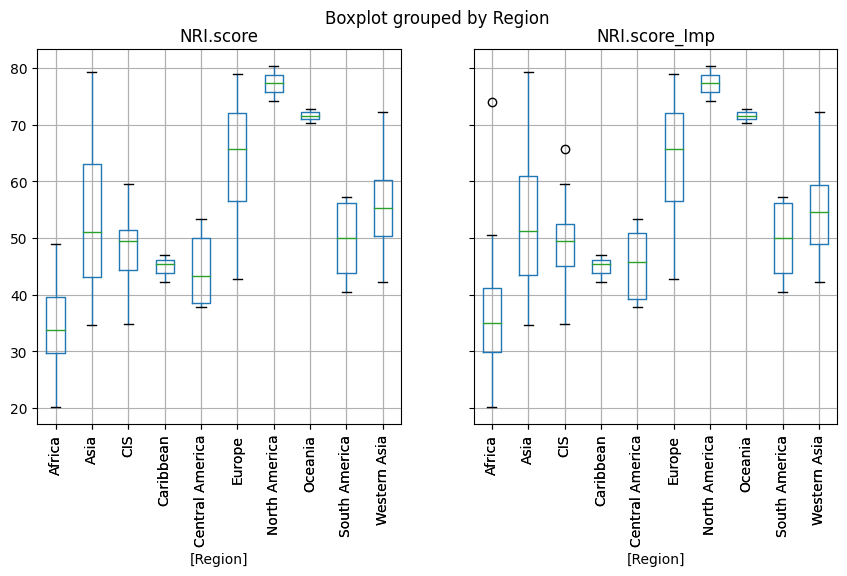

In [26]:
# Plotbox graph to compare the dispersion of NRI scores pre and post-imputation.
Dem_NRI_Imp = Dem2[['Region','NRI.score','NRI.score_Imp']]
boxplot_NRI = Dem_NRI_Imp.boxplot(by='Region', figsize = (10,5), rot = 90)

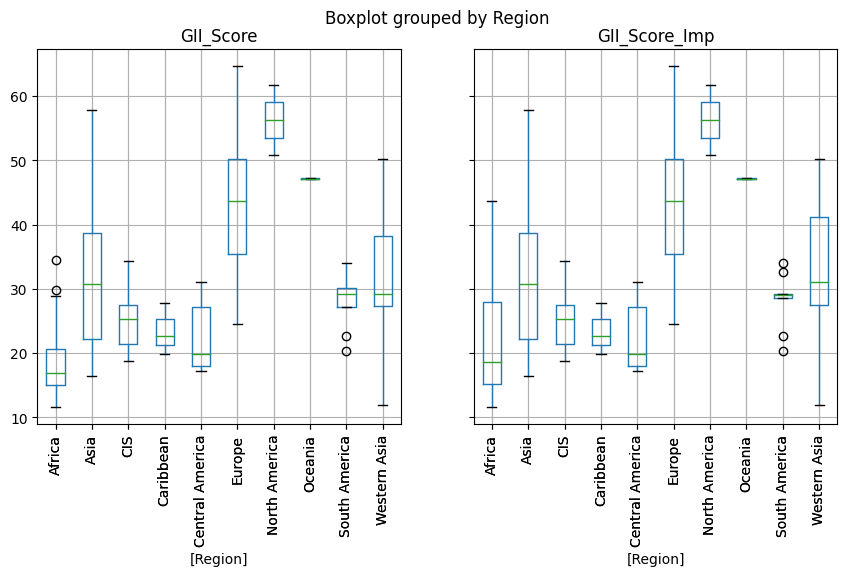

In [27]:
# Plotbox graph to compare the dispersion of E-Government Index pre and post-imputation.
Dem_EGov = Dem2[['Region','GII_Score','GII_Score_Imp']]
boxplot_EGov = Dem_EGov.boxplot(by='Region', figsize = (10,5), rot = 90)

An alternative method of imputation is the multivariate **IterativeImputer** experimental method.

In [28]:
# Imputing with the IterativeImputer:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iterative = IterativeImputer(max_iter=10, random_state=0)
ite = iterative.fit_transform(ImpDem)
IteDemGdp = pd.DataFrame(ite)
IteDemGdp.columns =ImpDem.columns
round(IteDemGdp,1)

M49 code  RegionNum   GDP_PC  Population  NRI.score  E-Government Index  \
0         8.0      600.0  14518.9   2811666.0       46.5                 0.7   
1        12.0      100.0  11039.8  44177969.0       39.5                 0.6   
2        24.0      100.0   5908.6  34503774.0       27.4                 0.4   
3        32.0      900.0  21527.2  45808747.0       53.0                 0.8   
4        51.0      300.0  14193.1   2790974.0       50.4                 0.7   
..        ...        ...      ...         ...        ...                 ...   
136     860.0      300.0   7734.8  34915100.0       48.9                 0.7   
137     704.0      200.0  10628.2  97468029.0       51.1                 0.7   
138     887.0     1000.0  11516.5  32981641.0       51.0                 0.3   
139     894.0      100.0   3236.8  19473125.0       34.0                 0.5   
140     716.0      100.0   2115.1  15993524.0       32.0                 0.5   

     GII_Score  Mobile tariffs  Handset prices  \
0         24.4            48.1            47.0   
1         16.7            46.8            30.4   
2         13.9            47.1            52.2   
3         28.6            47.3            51.7   
4         26.6            56.0            38.9   
..         ...             ...             ...   
136       25.3            54.5            42.3   
137       34.2            77.2            37.9   
138       13.8            53.9            48.2   
139       15.8            39.3            46.4   
140       18.1            15.2            21.3   

     Population covered by at least a 3G mobile network  ...  \
0                                                 99.7   ...   
1                                                 99.4   ...   
2                                                 95.4   ...   
3                                                 99.5   ...   
4                                                100.0   ...   
..                                                 ...   ...   
136                                               93.8   ...   
137                                               99.9   ...   
138                                               94.9   ...   
139                                               91.5   ...   
140                                               94.2   ...   

     Production and export complexity  Pupil-teacher ratio, secondary  \
0                                31.3                            89.2   
1                                17.5                            62.4   
2                                 6.7                            45.1   
3                                35.9                            76.2   
4                                35.3                            88.0   
..                                ...                             ...   
136                              30.3                            87.6   
137                              42.8                            64.0   
138                              15.2                            45.2   
139                              24.8                            60.2   
140                              20.2                            56.6   

     QS university ranking, top 3  Rule of law  School life expectancy, years  \
0                             0.0         36.8                           54.9   
1                             0.0         25.8                           54.1   
2                             0.0         21.1                           21.5   
3                            43.1         33.9                           78.3   
4                             0.0         43.9                           45.8   
..                            ...          ...                            ...   
136                           0.0         18.5                           41.4   
137                           8.1         42.6                           47.0   
138                           0.0          0.0                      

In [29]:
# Create a subset of the imputed data frame with the exogenous indexes to be tested: 
IteDemTest = IteDemGdp[['M49 code','RegionNum','NRI.score','E-Government Index','GII_Score']].rename(columns=lambda x: x+'_Ite')
IteDemTest

M49 code_Ite  RegionNum_Ite  NRI.score_Ite  E-Government Index_Ite  \
0             8.0          600.0      46.502931                  0.7413   
1            12.0          100.0      39.484971                  0.5611   
2            24.0          100.0      27.398558                  0.3789   
3            32.0          900.0      52.964534                  0.8198   
4            51.0          300.0      50.402620                  0.7364   
..            ...            ...            ...                     ...   
136         860.0          300.0      48.921541                  0.7265   
137         704.0          200.0      51.065508                  0.6787   
138         887.0         1000.0      50.952518                  0.2899   
139         894.0          100.0      34.017458                  0.5022   
140         716.0          100.0      31.951825                  0.4717   

     GII_Score_Ite  
0        24.441161  
1        16.696321  
2        13.920507  
3        28.623141  
4        26.591529  
..             ...  
136      25.306297  
137      34.249023  
138      13.762304  
139      15.800221  
140      18.095556  

[141 rows x 5 columns]

In [30]:
# Returns the missing values to compare them with the KNNImputer imputed (x_Imp) and the IterativeImputer (x_Ite)
Dem4 = pd.merge(
    Merge3[['Country or Area','M49 code','ISO-alpha3 code','Region','NRI.score','E-Government Index','GII_Score']],
    IteDemTest[['M49 code_Ite','NRI.score_Ite','E-Government Index_Ite','GII_Score_Ite']],
    left_on='M49 code', right_on='M49 code_Ite', how='left')
round(Dem4[Dem4['NRI.score'].isnull().values].sort_values(by=['NRI.score_Ite'], ascending = False),1)

Country or Area  M49 code ISO-alpha3 code           Region  NRI.score  \
17   Brunei Darussalam        96             BRN             Asia        NaN   
138              Yemen       887             YEM     Western Asia        NaN   
59                Iraq       368             IRQ     Western Asia        NaN   
81          Mauritania       478             MRT           Africa        NaN   
88             Myanmar       104             MMR             Asia        NaN   
93           Nicaragua       558             NIC  Central America        NaN   
94               Niger       562             NER           Africa        NaN   
125               Togo       768             TGO           Africa        NaN   
136         Uzbekistan       860             UZB              CIS        NaN   
10             Belarus       112             BLR              CIS        NaN   

     E-Government Index  GII_Score  M49 code_Ite  NRI.score_Ite  \
17                  0.7       22.2          96.0           51.0   
138                 0.3       13.8         887.0           51.0   
59                  0.4       11.9         368.0           49.8   
81                  0.3       12.4         478.0           49.7   
88                  0.5       16.4         104.0           49.6   
93                  0.5       18.1         558.0           49.5   
94                  0.2       14.6         562.0           49.4   
125                 0.4       15.1         768.0           49.2   
136                 0.7       25.3         860.0           48.9   
10                  0.8       27.5         112.0           48.3   

     E-Government Index_Ite  GII_Score_Ite  
17                      0.7           22.2  
138                     0.3           13.8  
59                      0.4           11.9  
81                      0.3           12.4  
88                      0.5           16.4  
93                      0.5           18.1  
94                      0.2           14.6  
125                     0.4           15.1  
136                     0.7           25.3  
10                      0.8           27.5

After imputing missing values with this *IterativeImputer* regressor method, it returns the average value for the countries with missing values.\
However, assigning all missing values with this average cannot be reliable. Thus, this experimental method is discarded.

<a id="Master_Dataset"></a>
# Master Dataset
Finally, consolidate one master dataset with the initial and imputed values.

In [31]:
Master = pd.merge(
    Merge3[['Country or Area','M49 code','ISO-alpha3 code','Region']],ImpDemGdp, left_on='M49 code', right_on='M49 code', how='left')
round(Master,1)

Country or Area  M49 code ISO-alpha3 code         Region  RegionNum  \
0           Albania         8             ALB         Europe      600.0   
1           Algeria        12             DZA         Africa      100.0   
2            Angola        24             AGO         Africa      100.0   
3         Argentina        32             ARG  South America      900.0   
4           Armenia        51             ARM            CIS      300.0   
..              ...       ...             ...            ...        ...   
136      Uzbekistan       860             UZB            CIS      300.0   
137        Viet Nam       704             VNM           Asia      200.0   
138           Yemen       887             YEM   Western Asia     1000.0   
139          Zambia       894             ZMB         Africa      100.0   
140        Zimbabwe       716             ZWE         Africa      100.0   

      GDP_PC  Population  NRI.score  E-Government Index  GII_Score  ...  \
0    14518.9   2811666.0       46.5                 0.7       24.4  ...   
1    11039.8  44177969.0       39.5                 0.6       16.7  ...   
2     5908.6  34503774.0       27.4                 0.4       13.9  ...   
3    21527.2  45808747.0       53.0                 0.8       28.6  ...   
4    14193.1   2790974.0       50.4                 0.7       26.6  ...   
..       ...         ...        ...                 ...        ...  ...   
136   7734.8  34915100.0       45.1                 0.7       25.3  ...   
137  10628.2  97468029.0       51.1                 0.7       34.2  ...   
138  14761.0  32981641.0       48.7                 0.3       13.8  ...   
139   3236.8  19473125.0       34.0                 0.5       15.8  ...   
140   2115.1  15993524.0       32.0                 0.5       18.1  ...   

     Production and export complexity  Pupil-teacher ratio, secondary  \
0                                31.3                            89.2   
1                                17.5                            90.7   
2                                 6.7                            45.1   
3                                35.9                            76.1   
4                                35.3                            88.0   
..                                ...                             ...   
136                              30.3                            87.6   
137                              42.8                            64.0   
138                              15.2                            45.2   
139                              24.8                            60.2   
140                              20.2                            56.6   

     QS university ranking, top 3  Rule of law  School life expectancy, years  \
0                             0.0         36.8                           54.9   
1                             0.0         25.8                           54.1   
2                             0.0         21.1                           21.5   
3                            43.1         33.9                           78.3   
4                             0.0         43.9                           45.8   
..                            ...          ...                            ...   
136                           0.0         18.5                           41.4   
137                           8.1         42.6                           62.2   
138                           0.0          0.0                           18.4   
139                           0.0         29.9                           62.6   
140                           0.0         13.0                           33.8   

     Scientific and technical articles/bn PPP$ GDP  Software spending, % GDP  \
0                                             10.6                      10.3   
1                                             14.5                       0.6   
2                                              0.0                      26.0   
3                               

In [32]:
Master.isnull().sum().sum() # Verify null values in the Master dataset.

0

In [33]:
# saving the excel
Master.to_excel('Indicators_Master.xlsx')
print('DataFrame is written to Excel File successfully.')

DataFrame is written to Excel File successfully.


<a id="Treatment_outliers"></a>
### Treatment of outliers and normalization

In [34]:
Indicators1 = Master.iloc[:,10:] # Create a data frame with only the individual indicators.
# 
# The descriptive statistics will show the indicators with outlier values: 
Stats = Indicators1.describe().transpose()
Stats

count       mean  \
Mobile tariffs                                      141.0  57.285368   
Handset prices                                      141.0  55.052594   
Population covered by at least a 3G mobile network  141.0  96.128970   
International Internet bandwidth                    141.0  70.379714   
GitHub commits                                      141.0  18.399645   
...                                                   ...        ...   
Scientific and technical articles/bn PPP$ GDP       141.0  28.537717   
Software spending, % GDP                            141.0  22.111276   
State of cluster development and depth              141.0  49.404563   
Trademarks by origin/bn PPP$ GDP                    141.0  33.201389   
University-industry R&D collaboration               141.0  46.302034   

                                                          std        min  \
Mobile tariffs                                      22.508677   0.000000   
Handset prices                                      21.340526   0.000000   
Population covered by at least a 3G mobile network  10.981364   0.000000   
International Internet bandwidth                    12.163842   0.000000   
GitHub commits                                      24.955944   0.000000   
...                                                       ...        ...   
Scientific and technical articles/bn PPP$ GDP       23.119627   0.000000   
Software spending, % GDP                            17.099631   0.000000   
State of cluster development and depth              10.719044  28.069274   
Trademarks by origin/bn PPP$ GDP                    26.320468   0.000000   
University-industry R&D collaboration               13.010572  18.678236   

                                                          25%        50%  \
Mobile tariffs                                      42.603099  56.943250   
Handset prices                                      40.607979  52.187626   
Population covered by at least a 3G mobile network  97.426580  99.566919   
International Internet bandwidth                    64.204399  71.033629   
GitHub commits                                       1.856657   5.853061   
...                                                       ...        ...   
Scientific and technical articles/bn PPP$ GDP       11.841220  22.202691   
Software spending, % GDP                             8.184828  20.589074   
State of cluster development and depth              42.439151  48.370449   
Trademarks by origin/bn PPP$ GDP                    11.734015  28.971358   
University-industry R&D collaboration               37.180591  44.445602   

                                                          75%         max  
Mobile tariffs                                      74.069481  100.000000  
Handset prices                                      71.539001  100.000000  
Population covered by at least a 3G mobile network  99.967736  100.000000  
International Internet bandwidth                    76.697165  100.000000  
GitHub commits                                      27.329678  100.000000  
...                                                       ...         ...  
Scientific and technical articles/bn PPP$ GDP       39.162087  100.000000  
Software spending, % GDP                            29.261912  100.000000  
State of cluster development and depth              56.151621   78.515840  
Trademarks by origin/bn PPP$ GDP                    49.604932  100.000000  
University-industry R&D collaboration               53.821667   79.640778  

[92 rows x 8 columns]

In [35]:
StatsMax = Stats[Stats['max'] >100] # Verify features with values greater than 100
StatsMax

StatsMin = Stats[Stats['min'] <0] # Verify features with values less than 0
StatsMin
# The 'SDG 7: Affordable and Clean Energy' indicator has a minimum value close to 0, it could be normalized to 0.

count       mean        std           min  \
SDG 7: Affordable and Clean Energy  141.0  73.689543  19.443507 -1.421085e-14   

                                          25%        50%        75%    max  
SDG 7: Affordable and Clean Energy  67.529936  79.114453  85.547201  100.0

Evaluate the presence of outliers in the Master dataset, it can be measured through skewness and kurtosis.

In [36]:
skew = Indicators1.skew()
Skewness = pd.DataFrame({'Skewness': abs(skew)})

# Filter only the indicators with more than an absolute value of 2.25 of Skewness: 
SkewAbs = Skewness[Skewness['Skewness'] >=2.25]
SkewAbs

Skewness
Population covered by at least a 3G mobile network  5.887179
Mobile app creation/bn PPP$ GDP                     3.412584

In [37]:
kurtos = Indicators1.kurtosis()
Kurtosis = pd.DataFrame({'Kurtosis': abs(kurtos)})

# Filter only the indicators with more than an absolute value of 3.5 of kurtosis: 
KurtosAbs = Kurtosis[Kurtosis['Kurtosis'] >=3.5]
KurtosAbs

Kurtosis
Population covered by at least a 3G mobile network  44.047962
International Internet bandwidth                     7.298958
Active Mobile Broadband Subscriptions Count          4.089815
ICT regulatory environment                           4.393146
Cost of redundancy dismissal                         4.136726
Country-code TLDs/th pop. 15–69                      3.599343
Creative goods exports, % total trade                4.356415
Cultural and creative services exports, % total...   5.534321
FDI net inflows, % GDP                               7.694793
GDP/unit of energy use                               3.563631
Generic top-level domains (TLDs)/th pop. 15–69       4.031511
Gross capital formation, % GDP                       4.010972
Gross expenditure on R&D, % GDP                      3.904328
High-tech imports, % total trade                     5.098723
Industrial designs by origin/bn PPP$ GDP             3.848662
Intellectual property receipts, % total trade        4.062176
ISO 14001 environmental certificates/bn PPP$ GDP     3.787295
ISO 9001 quality certificates/bn PPP$ GDP            3.915870
Joint venture/strategic alliance deals/bn PPP$ GDP   4.070990
Mobile app creation/bn PPP$ GDP                     17.591548
New businesses/th pop. 15–64                         4.033176
Patent families/bn PPP$ GDP                          3.525802
Patents by origin/bn PPP$ GDP                        3.830192

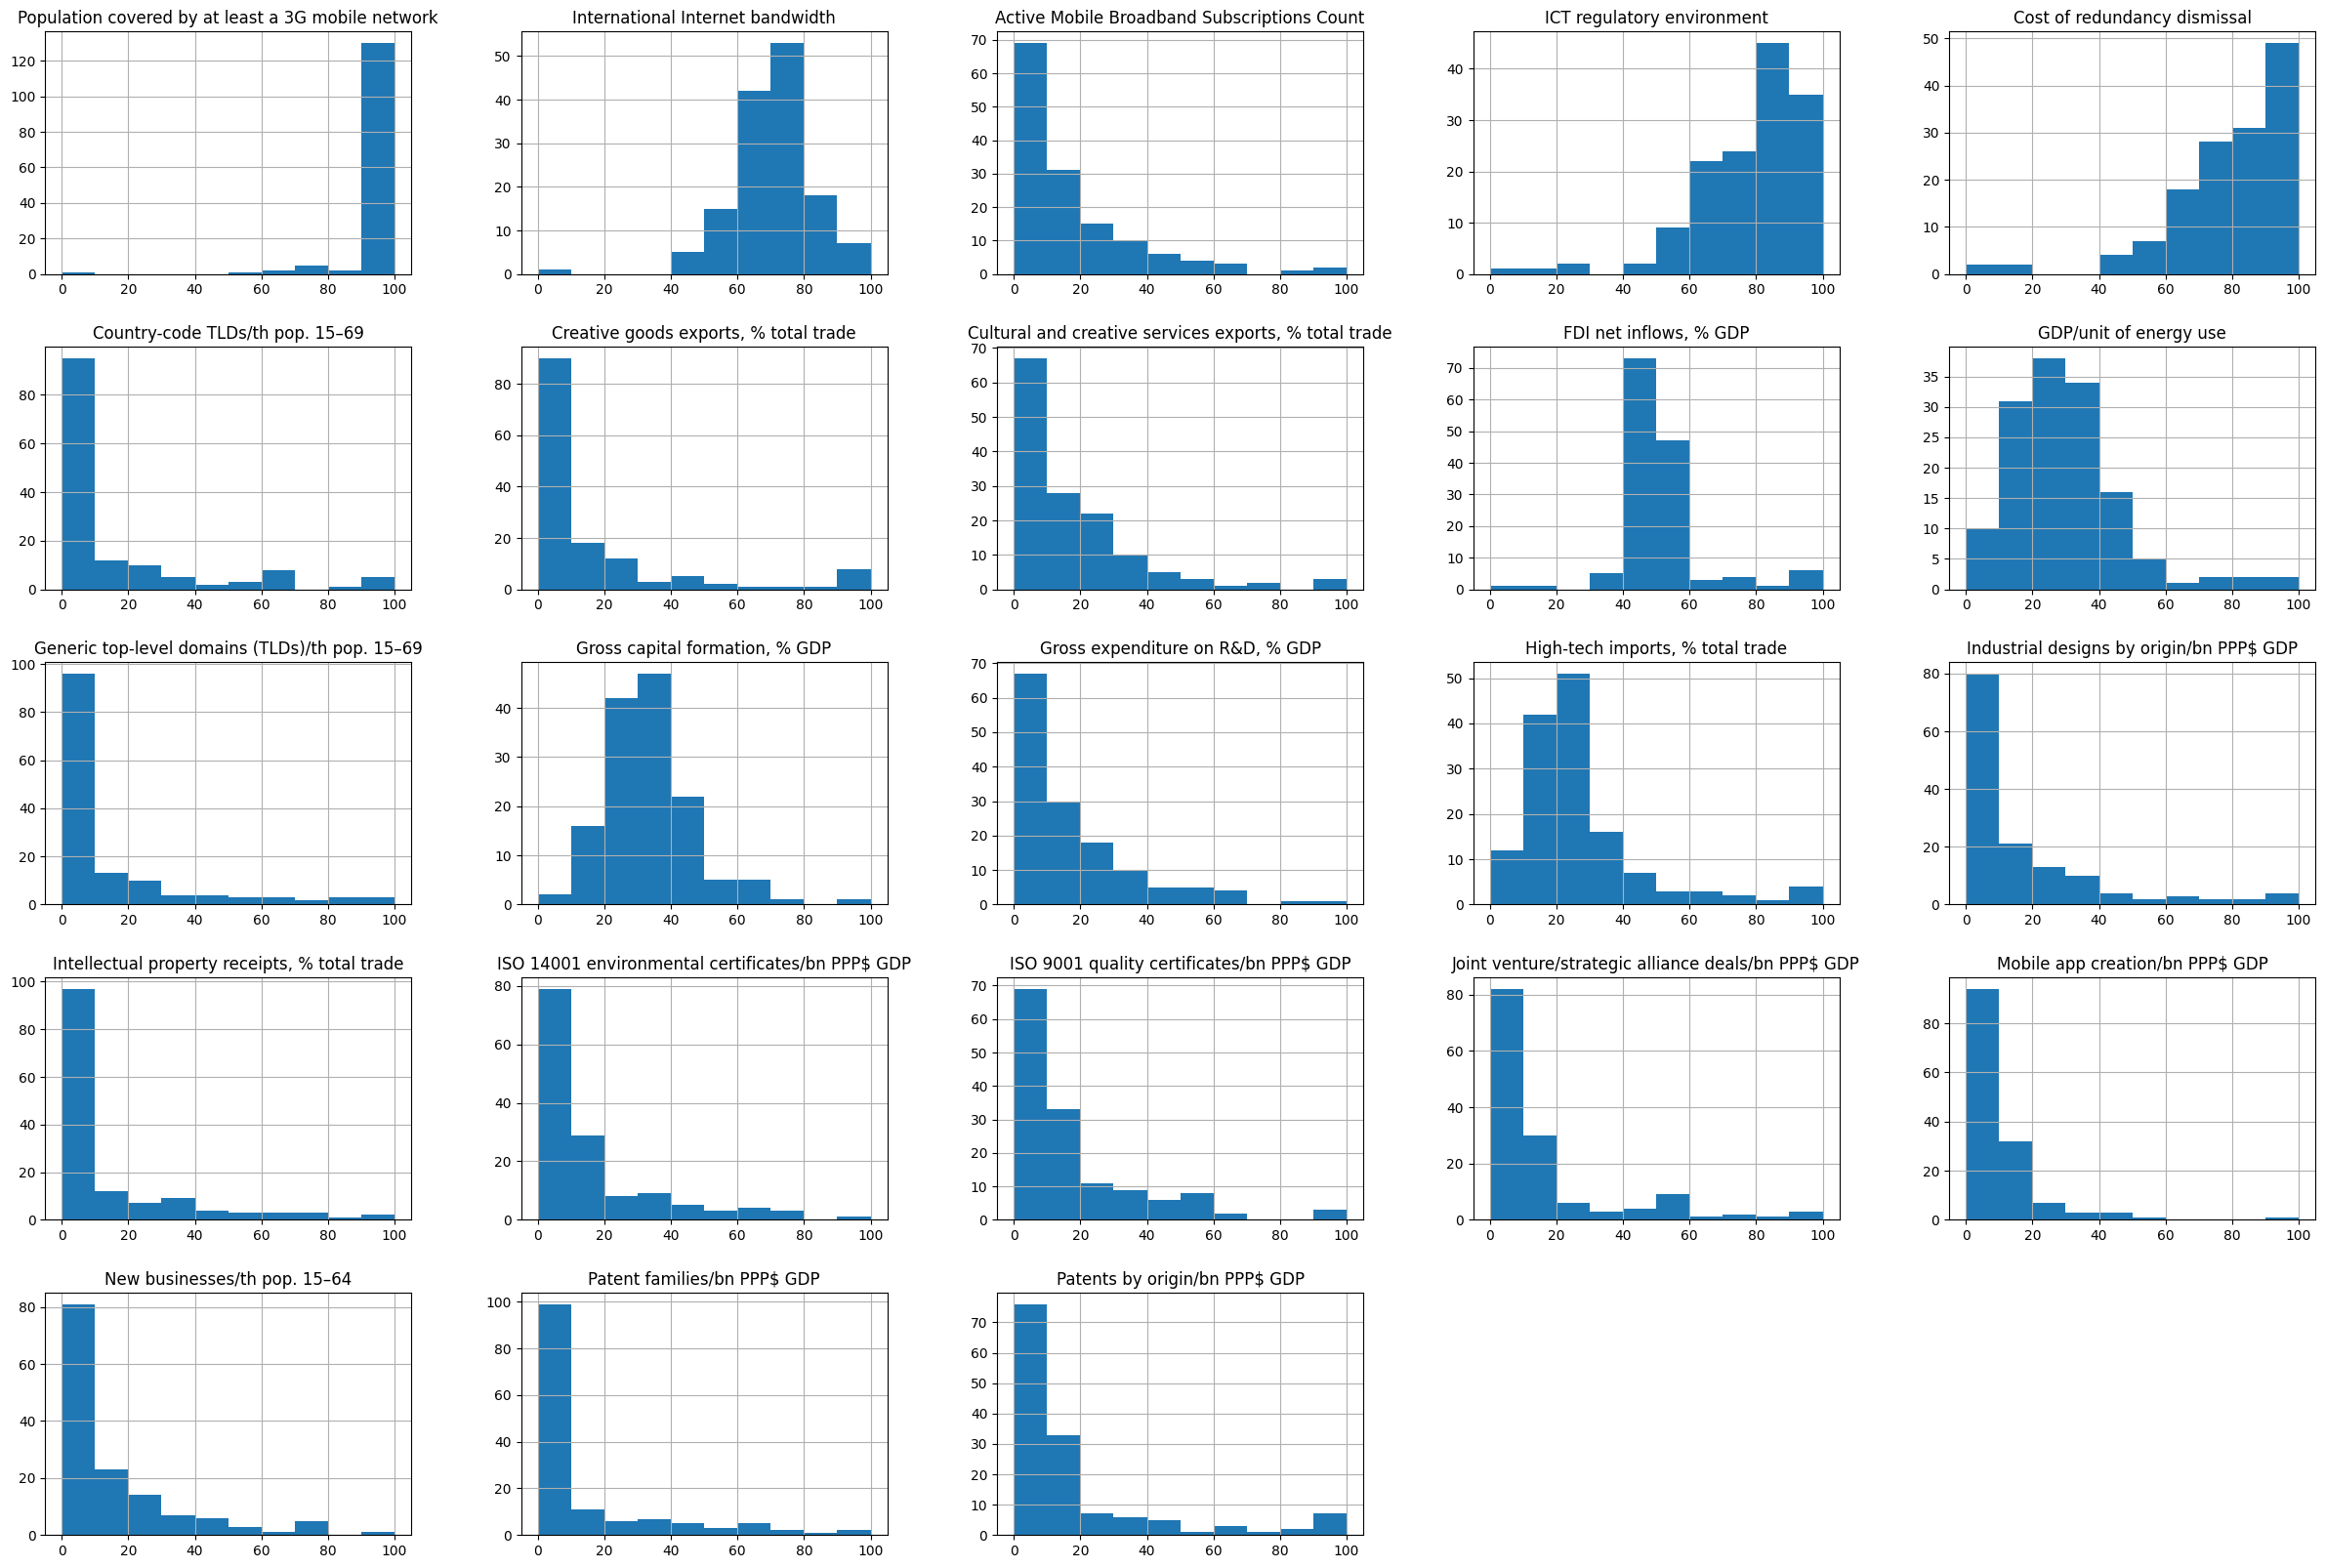

In [38]:
# Histogram plots of the indicators with kurtosis
Indicators1.hist(KurtosAbs.index,figsize=(30, 20))
plt.show()

Given that previous individual indicators have values between [0,100], they are already normalized, but kurtosis is present in some of them.\
Now, normalizing the exogenous indexes.

In [39]:
# Define the indexes columns to normalize: 
x = Master[['NRI.score']] 
z = Master[['GII_Score']] 

# Normalize and standardize values of external index:
if 'NRI_Nor' in Master.columns:
    Master.drop('NRI_Nor', axis=1, inplace=True)
    Master.insert(loc=8, column='NRI_Nor', value = (x-x.min())/ (x.max() - x.min()))
else: Master.insert(loc=8, column='NRI_Nor', value = (x-x.min())/ (x.max() - x.min()))

if 'GII_Nor' in Master.columns:
    Master.drop('GII_Nor', axis=1, inplace=True)
    Master.insert(loc=9, column='GII_Nor', value = (z-z.min())/ (z.max() - z.min()))
else: Master.insert(loc=9, column='GII_Nor', value = (z-z.min())/ (z.max() - z.min()))

# Add the log scale of the GDP_PC:
if 'GDP_PC_log' in Master.columns:
    Master.drop('GDP_PC_log', axis=1, inplace=True)
    Master.insert(loc=6, column='GDP_PC_log', value=np.log(Master.GDP_PC))
else: Master.insert(loc=6, column='GDP_PC_log', value=np.log(Master.GDP_PC))

Master

Country or Area  M49 code ISO-alpha3 code         Region  RegionNum  \
0           Albania         8             ALB         Europe      600.0   
1           Algeria        12             DZA         Africa      100.0   
2            Angola        24             AGO         Africa      100.0   
3         Argentina        32             ARG  South America      900.0   
4           Armenia        51             ARM            CIS      300.0   
..              ...       ...             ...            ...        ...   
136      Uzbekistan       860             UZB            CIS      300.0   
137        Viet Nam       704             VNM           Asia      200.0   
138           Yemen       887             YEM   Western Asia     1000.0   
139          Zambia       894             ZMB         Africa      100.0   
140        Zimbabwe       716             ZWE         Africa      100.0   

           GDP_PC  GDP_PC_log  Population  NRI.score   NRI_Nor  ...  \
0    14518.906550    9.583207   2811666.0  46.502931  0.438363  ...   
1    11039.805261    9.309263  44177969.0  39.484971  0.321742  ...   
2     5908.570045    8.684159  34503774.0  27.398558  0.120895  ...   
3    21527.196137    9.977072  45808747.0  52.964534  0.545739  ...   
4    14193.116834    9.560512   2790974.0  50.402620  0.503166  ...   
..            ...         ...         ...        ...       ...  ...   
136   7734.832414    8.953489  34915100.0  45.066117  0.414487  ...   
137  10628.219166    9.271268  97468029.0  51.065508  0.514182  ...   
138  14761.015145    9.599745  32981641.0  48.727116  0.475324  ...   
139   3236.788981    8.082337  19473125.0  34.017458  0.230885  ...   
140   2115.144555    7.656878  15993524.0  31.951825  0.196559  ...   

     Production and export complexity  Pupil-teacher ratio, secondary  \
0                           31.271851                       89.153804   
1                           17.493755                       90.679450   
2                            6.718018                       45.146582   
3                           35.897857                       76.147025   
4                           35.291193                       87.996913   
..                                ...                             ...   
136                         30.276604                       87.645641   
137                         42.841842                       64.001462   
138                         15.213214                       45.161587   
139                         24.807733                       60.212940   
140                         20.188581                       56.587670   

     QS university ranking, top 3  Rule of law  School life expectancy, years  \
0                        0.000000    36.786080                      54.897111   
1                        0.000000    25.839911                      54.107096   
2                        0.000000    21.097168                      21.527504   
3                       43.100000    33.905031                      78.292196   
4                        0.000000    43.920698                      45.808796   
..                            ...          ...                            ...   
136                      0.000000    18.512628                      41.442140   
137                      8.133333    42.605443                      62.212807   
138                      0.000000     0.000000                      18.377752   
139                      0.000000    29.932892                      62.593819   
140                      0.000000    13.013028                      33.789124   

     Scientific and technical articles/bn PPP$ GDP  Software spending, % GDP  \
0                                        10.584941                 10.254291   
1                                        14.530092                  0.599540   
2                                         0.000000                 25.979984   
3                                        14.698607                 22.231912   


In [40]:
# Add a column with the mean of exogenous indexes.
if 'Mean Exo Indexes' in Master.columns:
    Master.drop('Mean Exo Indexes', axis=1, inplace=True)
    Master.insert(loc=8, column='Mean Exo Indexes', value = Master[['NRI_Nor', 'E-Government Index','GII_Nor']].mean(1))
else: Master.insert(loc=8, column='Mean Exo Indexes', value = Master[['NRI_Nor', 'E-Government Index','GII_Nor']].mean(1))

Master

Country or Area  M49 code ISO-alpha3 code         Region  RegionNum  \
0           Albania         8             ALB         Europe      600.0   
1           Algeria        12             DZA         Africa      100.0   
2            Angola        24             AGO         Africa      100.0   
3         Argentina        32             ARG  South America      900.0   
4           Armenia        51             ARM            CIS      300.0   
..              ...       ...             ...            ...        ...   
136      Uzbekistan       860             UZB            CIS      300.0   
137        Viet Nam       704             VNM           Asia      200.0   
138           Yemen       887             YEM   Western Asia     1000.0   
139          Zambia       894             ZMB         Africa      100.0   
140        Zimbabwe       716             ZWE         Africa      100.0   

           GDP_PC  GDP_PC_log  Population  Mean Exo Indexes  NRI.score  ...  \
0    14518.906550    9.583207   2811666.0          0.474069  46.502931  ...   
1    11039.805261    9.309263  44177969.0          0.326462  39.484971  ...   
2     5908.570045    8.684159  34503774.0          0.181337  27.398558  ...   
3    21527.196137    9.977072  45808747.0          0.562307  52.964534  ...   
4    14193.116834    9.560512   2790974.0          0.507550  50.402620  ...   
..            ...         ...         ...               ...        ...  ...   
136   7734.832414    8.953489  34915100.0          0.466614  45.066117  ...   
137  10628.219166    9.271268  97468029.0          0.540106  51.065508  ...   
138  14761.015145    9.599745  32981641.0          0.268819  48.727116  ...   
139   3236.788981    8.082337  19473125.0          0.270912  34.017458  ...   
140   2115.144555    7.656878  15993524.0          0.263727  31.951825  ...   

     Production and export complexity  Pupil-teacher ratio, secondary  \
0                           31.271851                       89.153804   
1                           17.493755                       90.679450   
2                            6.718018                       45.146582   
3                           35.897857                       76.147025   
4                           35.291193                       87.996913   
..                                ...                             ...   
136                         30.276604                       87.645641   
137                         42.841842                       64.001462   
138                         15.213214                       45.161587   
139                         24.807733                       60.212940   
140                         20.188581                       56.587670   

     QS university ranking, top 3  Rule of law  School life expectancy, years  \
0                        0.000000    36.786080                      54.897111   
1                        0.000000    25.839911                      54.107096   
2                        0.000000    21.097168                      21.527504   
3                       43.100000    33.905031                      78.292196   
4                        0.000000    43.920698                      45.808796   
..                            ...          ...                            ...   
136                      0.000000    18.512628                      41.442140   
137                      8.133333    42.605443                      62.212807   
138                      0.000000     0.000000                      18.377752   
139                      0.000000    29.932892                      62.593819   
140                      0.000000    13.013028                      33.789124   

     Scientific and technical articles/bn PPP$ GDP  Software spending, % GDP  \
0                                        10.584941                 10.254291   
1                                        14.530092                  0.599540   
2                                         0.000000              

<a id="Clustering"></a>
# Clustering
Before starting the clustering on the dataset, it is necessary to identify the optimal number of K-Means clusters using the Elbow method. 

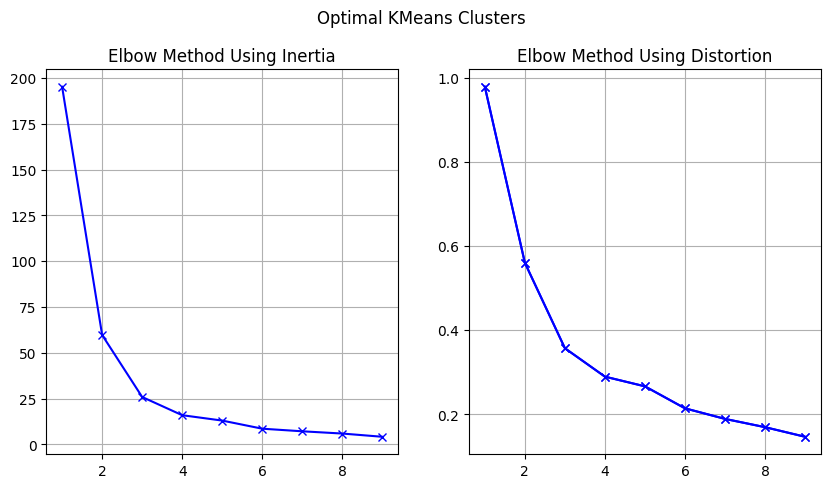

In [41]:
import warnings
warnings.filterwarnings('ignore') # Ignore the warning memory temporary message "OMP_NUM_THREADS=1"

X = Master[['Mean Exo Indexes', 'GDP_PC_log']].values
np.random.seed(42)
inertia = []
distortions = []

for i in range(1, 10): # Iterating the process
    model = KMeans(n_clusters=i, n_init='auto')  # Instantiate the model
    model.fit(X)  # Fit The Model
    inertia.append(model.inertia_)  # Extract the error of the model
    distortions.append(sum(np.min(cdist(X, model.cluster_centers_,'euclidean'), axis=1)) / X.shape[0])

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) # Create a panel with 2 subplots (1x2)
plt.plot(range(1, 10), distortions, 'bx-') #Visualize the model
axs[0].plot(range(1, 10), inertia, 'bx-')
axs[0].set_title("Elbow Method Using Inertia")
axs[0].grid()
axs[1].plot(range(1, 10), distortions, 'bx-')
axs[1].set_title("Elbow Method Using Distortion")
axs[1].grid()
plt.suptitle("Optimal KMeans Clusters").set_y(1)
plt.show()


An alternative measure to find the optimal K clusters is through the **silhouette_score** shown below, which returns the highest coefficient between 2 and 3 clusters. Therefore, a value of K=3 will be chosen for practicality to continue with the exercise.

In [42]:
from sklearn.metrics import silhouette_score
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For k={}, the Silhouette Coefficient is {}".format(k, sil_coeff))

For k=2, the Silhouette Coefficient is 0.5793075777350929
For k=3, the Silhouette Coefficient is 0.5779147392467688
For k=4, the Silhouette Coefficient is 0.5502256008375952
For k=5, the Silhouette Coefficient is 0.5270432089217543
For k=6, the Silhouette Coefficient is 0.4845296169713633
For k=7, the Silhouette Coefficient is 0.4789051099254293
For k=8, the Silhouette Coefficient is 0.49653745755702555
For k=9, the Silhouette Coefficient is 0.4917084937239046
For k=10, the Silhouette Coefficient is 0.5028092497256939


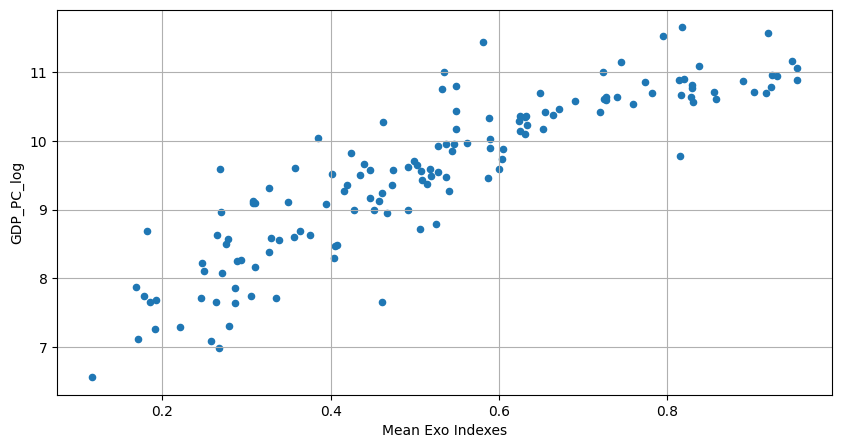

In [43]:
# Generate a scatter plot with the mean of all indexes and the log of GDP_PC_Imp
Master.plot.scatter(x = 'Mean Exo Indexes', y = 'GDP_PC_log', figsize = (10,5))
plt.grid()

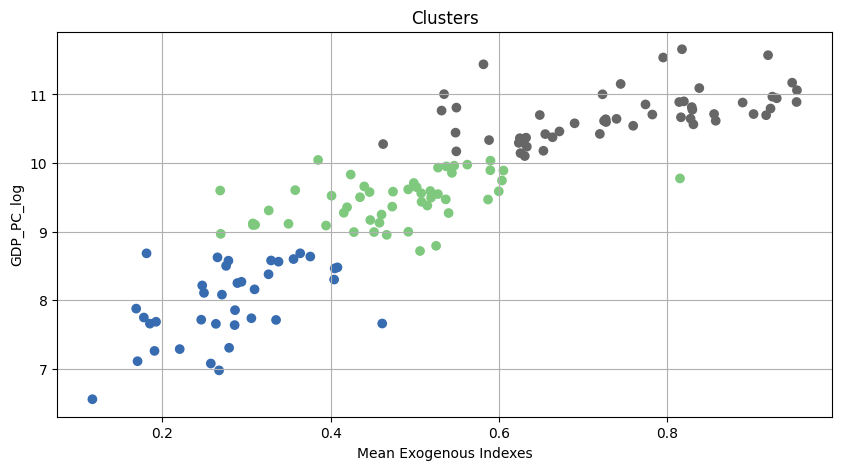

In [44]:
# Clustering with the KMeans method.

from sklearn.cluster import KMeans
np.random.seed(42) #Instantiate the model
y_pred = KMeans(n_clusters=3 ).fit_predict(X)

plt.figure(figsize=(10, 5))
plt.scatter(X[:, 0], X[:, 1], c=y_pred , cmap='Accent')
plt.title('Clusters')
plt.xlabel('Mean Exogenous Indexes')
plt.ylabel('GDP_PC_log')
plt.grid()
plt.show()

In [45]:
Master['Cluster'] = y_pred # Add a column with the cluster category.

# Create a Dictionary with the Clusters and associate a Cluster Name.
ClusterNum = Master['Cluster'].sort_values().unique().tolist()
ClusterNames = dict(zip(ClusterNum, list(['b_Middle', 'a_Low', 'c_High'])))

Master['ClusterNames'] = Master['Cluster'].map(ClusterNames) # Add a column with the cluster name
Master

Country or Area  M49 code ISO-alpha3 code         Region  RegionNum  \
0           Albania         8             ALB         Europe      600.0   
1           Algeria        12             DZA         Africa      100.0   
2            Angola        24             AGO         Africa      100.0   
3         Argentina        32             ARG  South America      900.0   
4           Armenia        51             ARM            CIS      300.0   
..              ...       ...             ...            ...        ...   
136      Uzbekistan       860             UZB            CIS      300.0   
137        Viet Nam       704             VNM           Asia      200.0   
138           Yemen       887             YEM   Western Asia     1000.0   
139          Zambia       894             ZMB         Africa      100.0   
140        Zimbabwe       716             ZWE         Africa      100.0   

           GDP_PC  GDP_PC_log  Population  Mean Exo Indexes  NRI.score  ...  \
0    14518.906550    9.583207   2811666.0          0.474069  46.502931  ...   
1    11039.805261    9.309263  44177969.0          0.326462  39.484971  ...   
2     5908.570045    8.684159  34503774.0          0.181337  27.398558  ...   
3    21527.196137    9.977072  45808747.0          0.562307  52.964534  ...   
4    14193.116834    9.560512   2790974.0          0.507550  50.402620  ...   
..            ...         ...         ...               ...        ...  ...   
136   7734.832414    8.953489  34915100.0          0.466614  45.066117  ...   
137  10628.219166    9.271268  97468029.0          0.540106  51.065508  ...   
138  14761.015145    9.599745  32981641.0          0.268819  48.727116  ...   
139   3236.788981    8.082337  19473125.0          0.270912  34.017458  ...   
140   2115.144555    7.656878  15993524.0          0.263727  31.951825  ...   

     QS university ranking, top 3  Rule of law  School life expectancy, years  \
0                        0.000000    36.786080                      54.897111   
1                        0.000000    25.839911                      54.107096   
2                        0.000000    21.097168                      21.527504   
3                       43.100000    33.905031                      78.292196   
4                        0.000000    43.920698                      45.808796   
..                            ...          ...                            ...   
136                      0.000000    18.512628                      41.442140   
137                      8.133333    42.605443                      62.212807   
138                      0.000000     0.000000                      18.377752   
139                      0.000000    29.932892                      62.593819   
140                      0.000000    13.013028                      33.789124   

     Scientific and technical articles/bn PPP$ GDP  Software spending, % GDP  \
0                                        10.584941                 10.254291   
1                                        14.530092                  0.599540   
2                                         0.000000                 25.979984   
3                                        14.698607                 22.231912   
4                                        27.046726                 11.667545   
..                                             ...                       ...   
136                                       2.752355                 25.979984   
137                                      13.255284                 25.094965   
138                                      23.766844                  3.402223   
139                                      14.289142                  2.619811   
140                                      29.356730                 21.606726   

     State of cluster development and depth  Trademarks by origin/bn PPP$ GDP  \
0                                 28.853762                         21.975506   
1                                 48.294218               

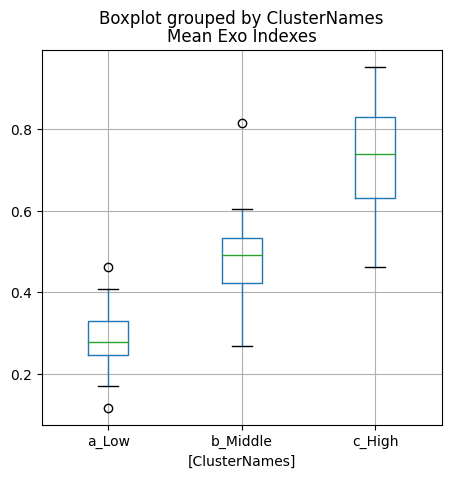

In [46]:
# Plotbox graph to compare the dispersion of Mean Exogenous Indexes across clusters.
Clu_ExoInd = Master[['ClusterNames','Mean Exo Indexes']]
boxplot_Clu = Clu_ExoInd.boxplot(by='ClusterNames', figsize = (5,5) )

An alternative clustering method is through a **Clustering Map**, in which all individual indicators and countries will be clustered according to their inner variance.

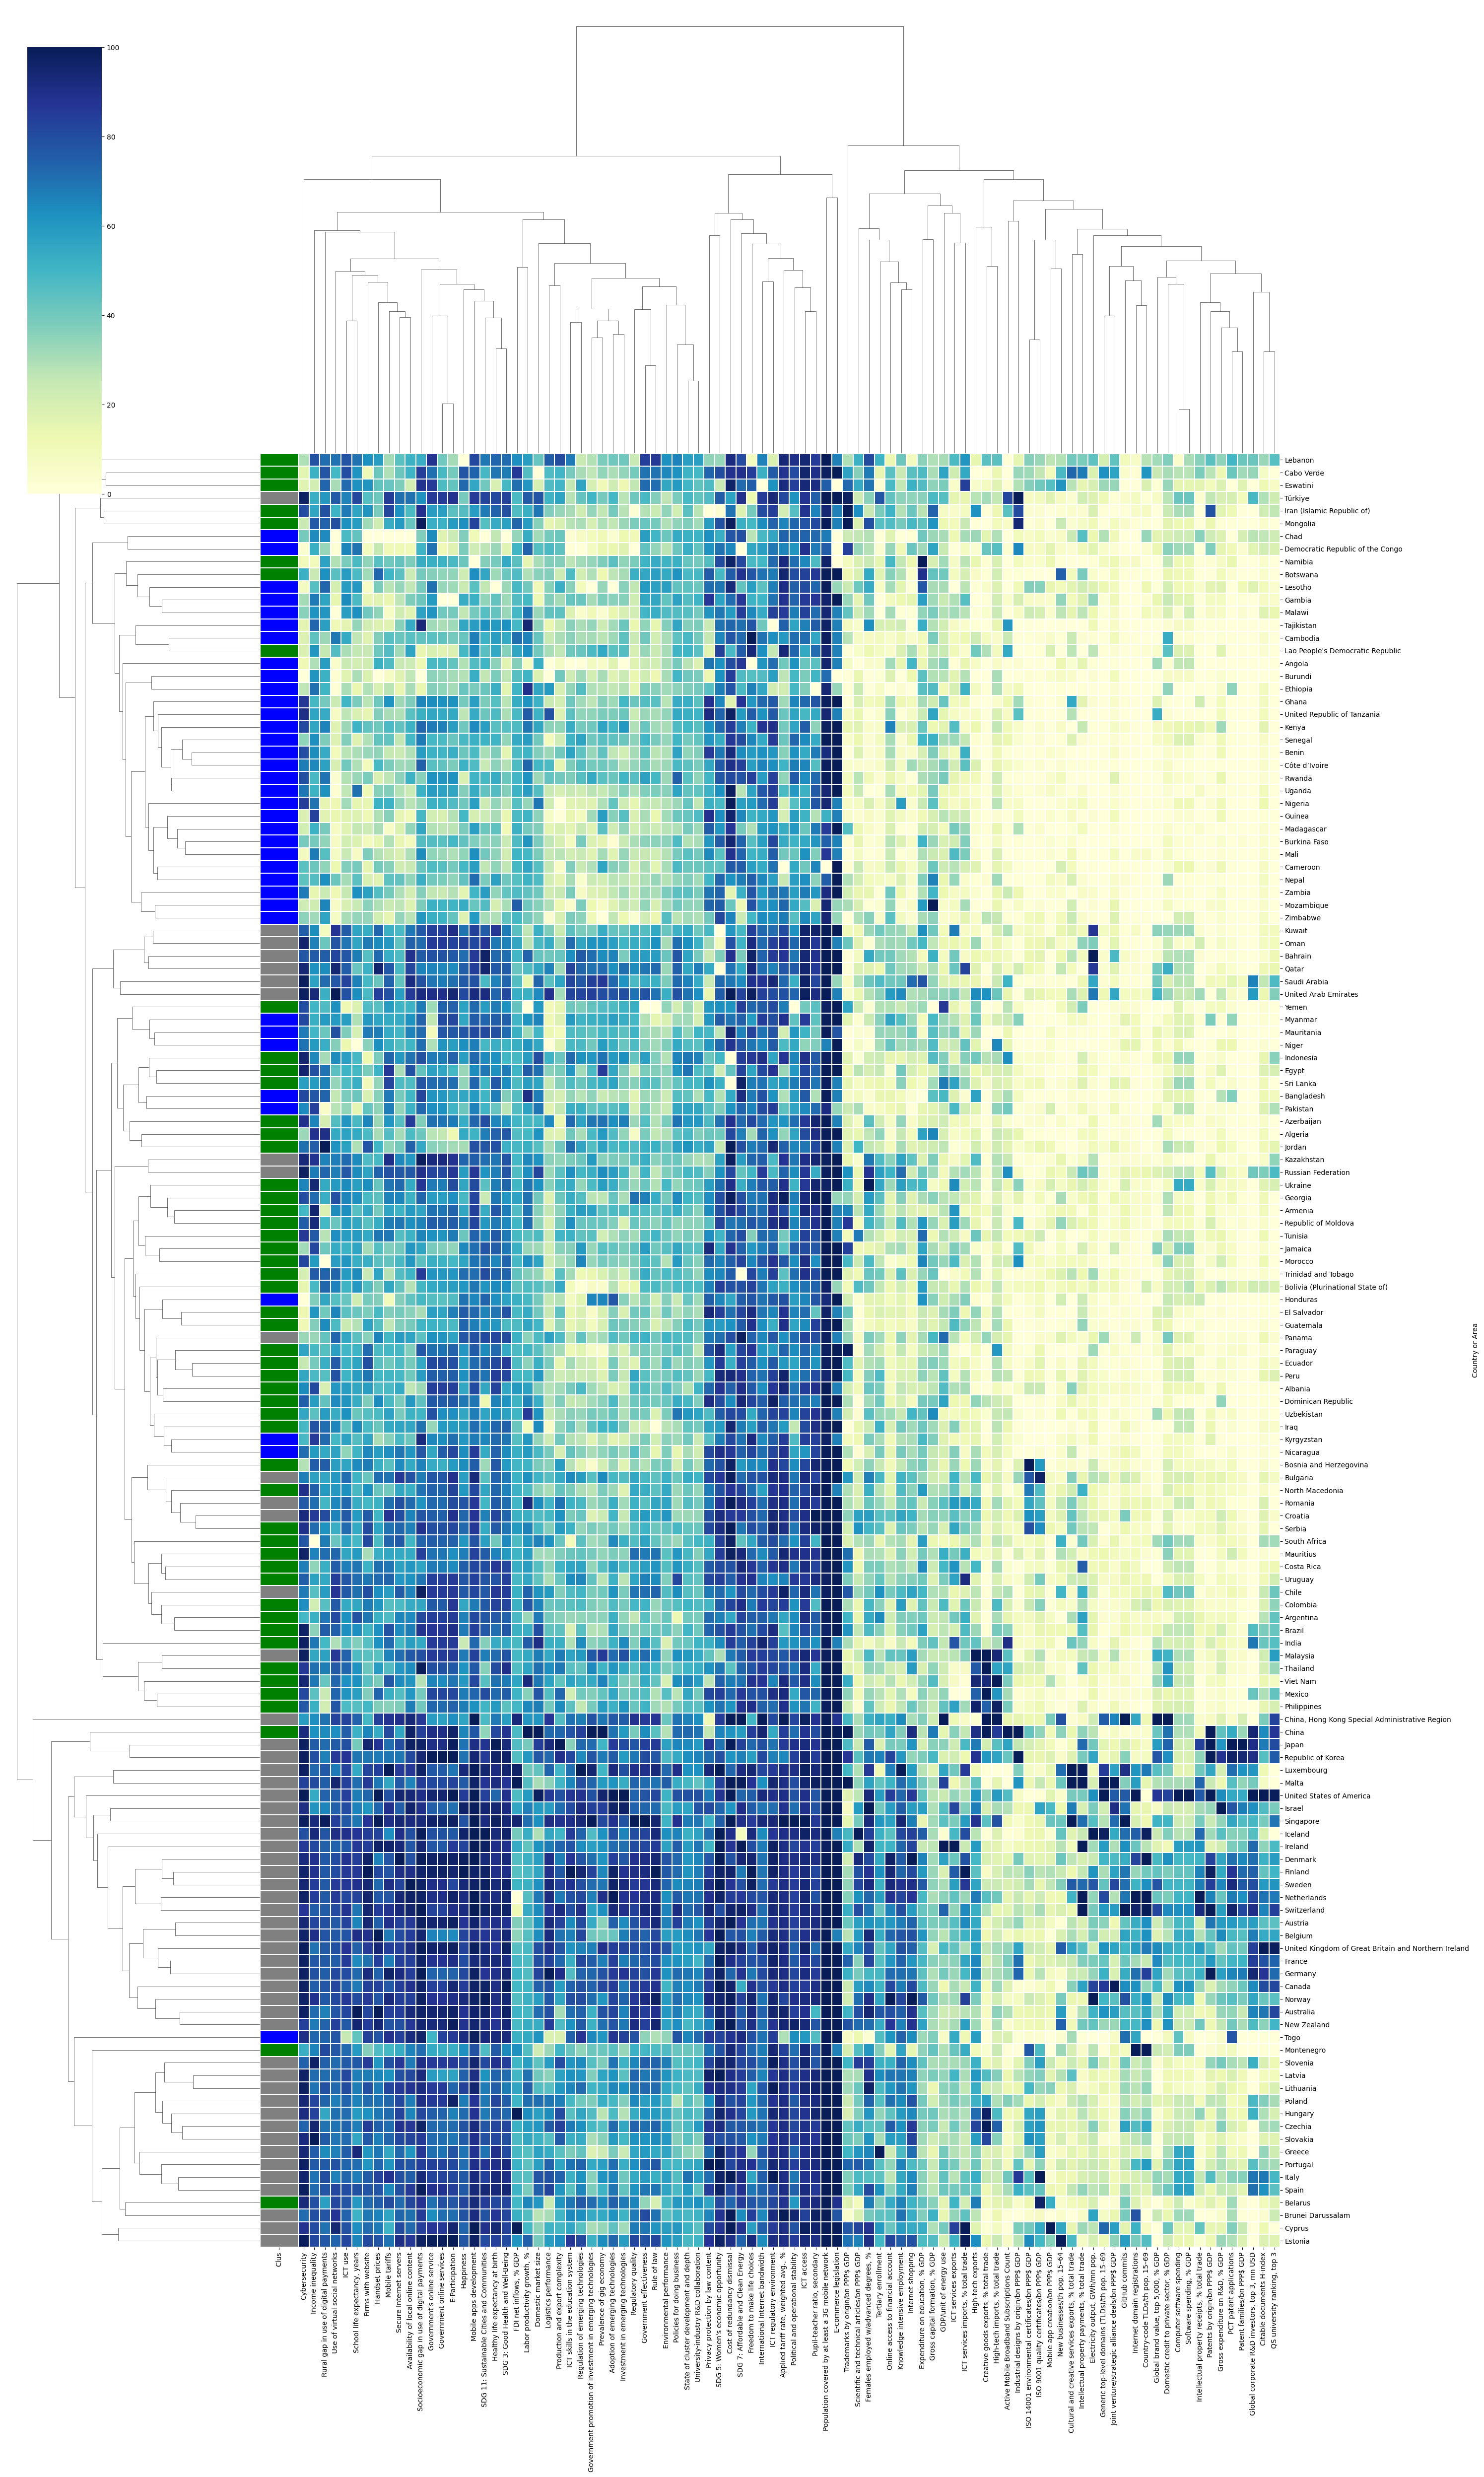

In [47]:
Indicators2 = Master.iloc[:,14:106] # Create a data frame with only the lastly imputed indicators.
Indicators2.set_index(Master['Country or Area'], inplace=True)

# Define colours for previously clustered countries
color_dict = dict(zip(np.unique(Master['ClusterNames']),np.array(['blue','green','grey'])))
target_df = Master[['Country or Area','ClusterNames']]
target_df['Clus'] = target_df['ClusterNames'].map(color_dict) 
target_colors = target_df[['Clus']]
target_colors.set_index(target_df['Country or Area'], inplace=True)

cgCountries = sns.clustermap(Indicators2, cmap ="YlGnBu", figsize=(30, 50), linewidths = 0.1, row_colors = target_colors);
plt.setp(cgCountries.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)
cgCountries # The image will take a minute to load.
#plt.savefig("clustermap.png") #Save the image file in the current working directory.

As shown in the Cluster Map, the hierarchic dendrograms cluster countries through the vertical axis with similar income levels, i.e. dark gray for high-income countries, green for middle-income, and blue for low-income. Although some noise with irregular countries (Kuwait, Qatar, Saudi Arabia, UAE) is reported within each cluster. \
In the same way, hierarchical dendrograms cluster indicators in the horizontal axis, where highly correlated indicators are grouped close to each other to form aggregate indicators.

<a id="Correlation_Analysis"></a>
# Correlation Analysis
Perform feature selection using a correlation matrix across different sets of countries to test if each set has a different combination of indicators.

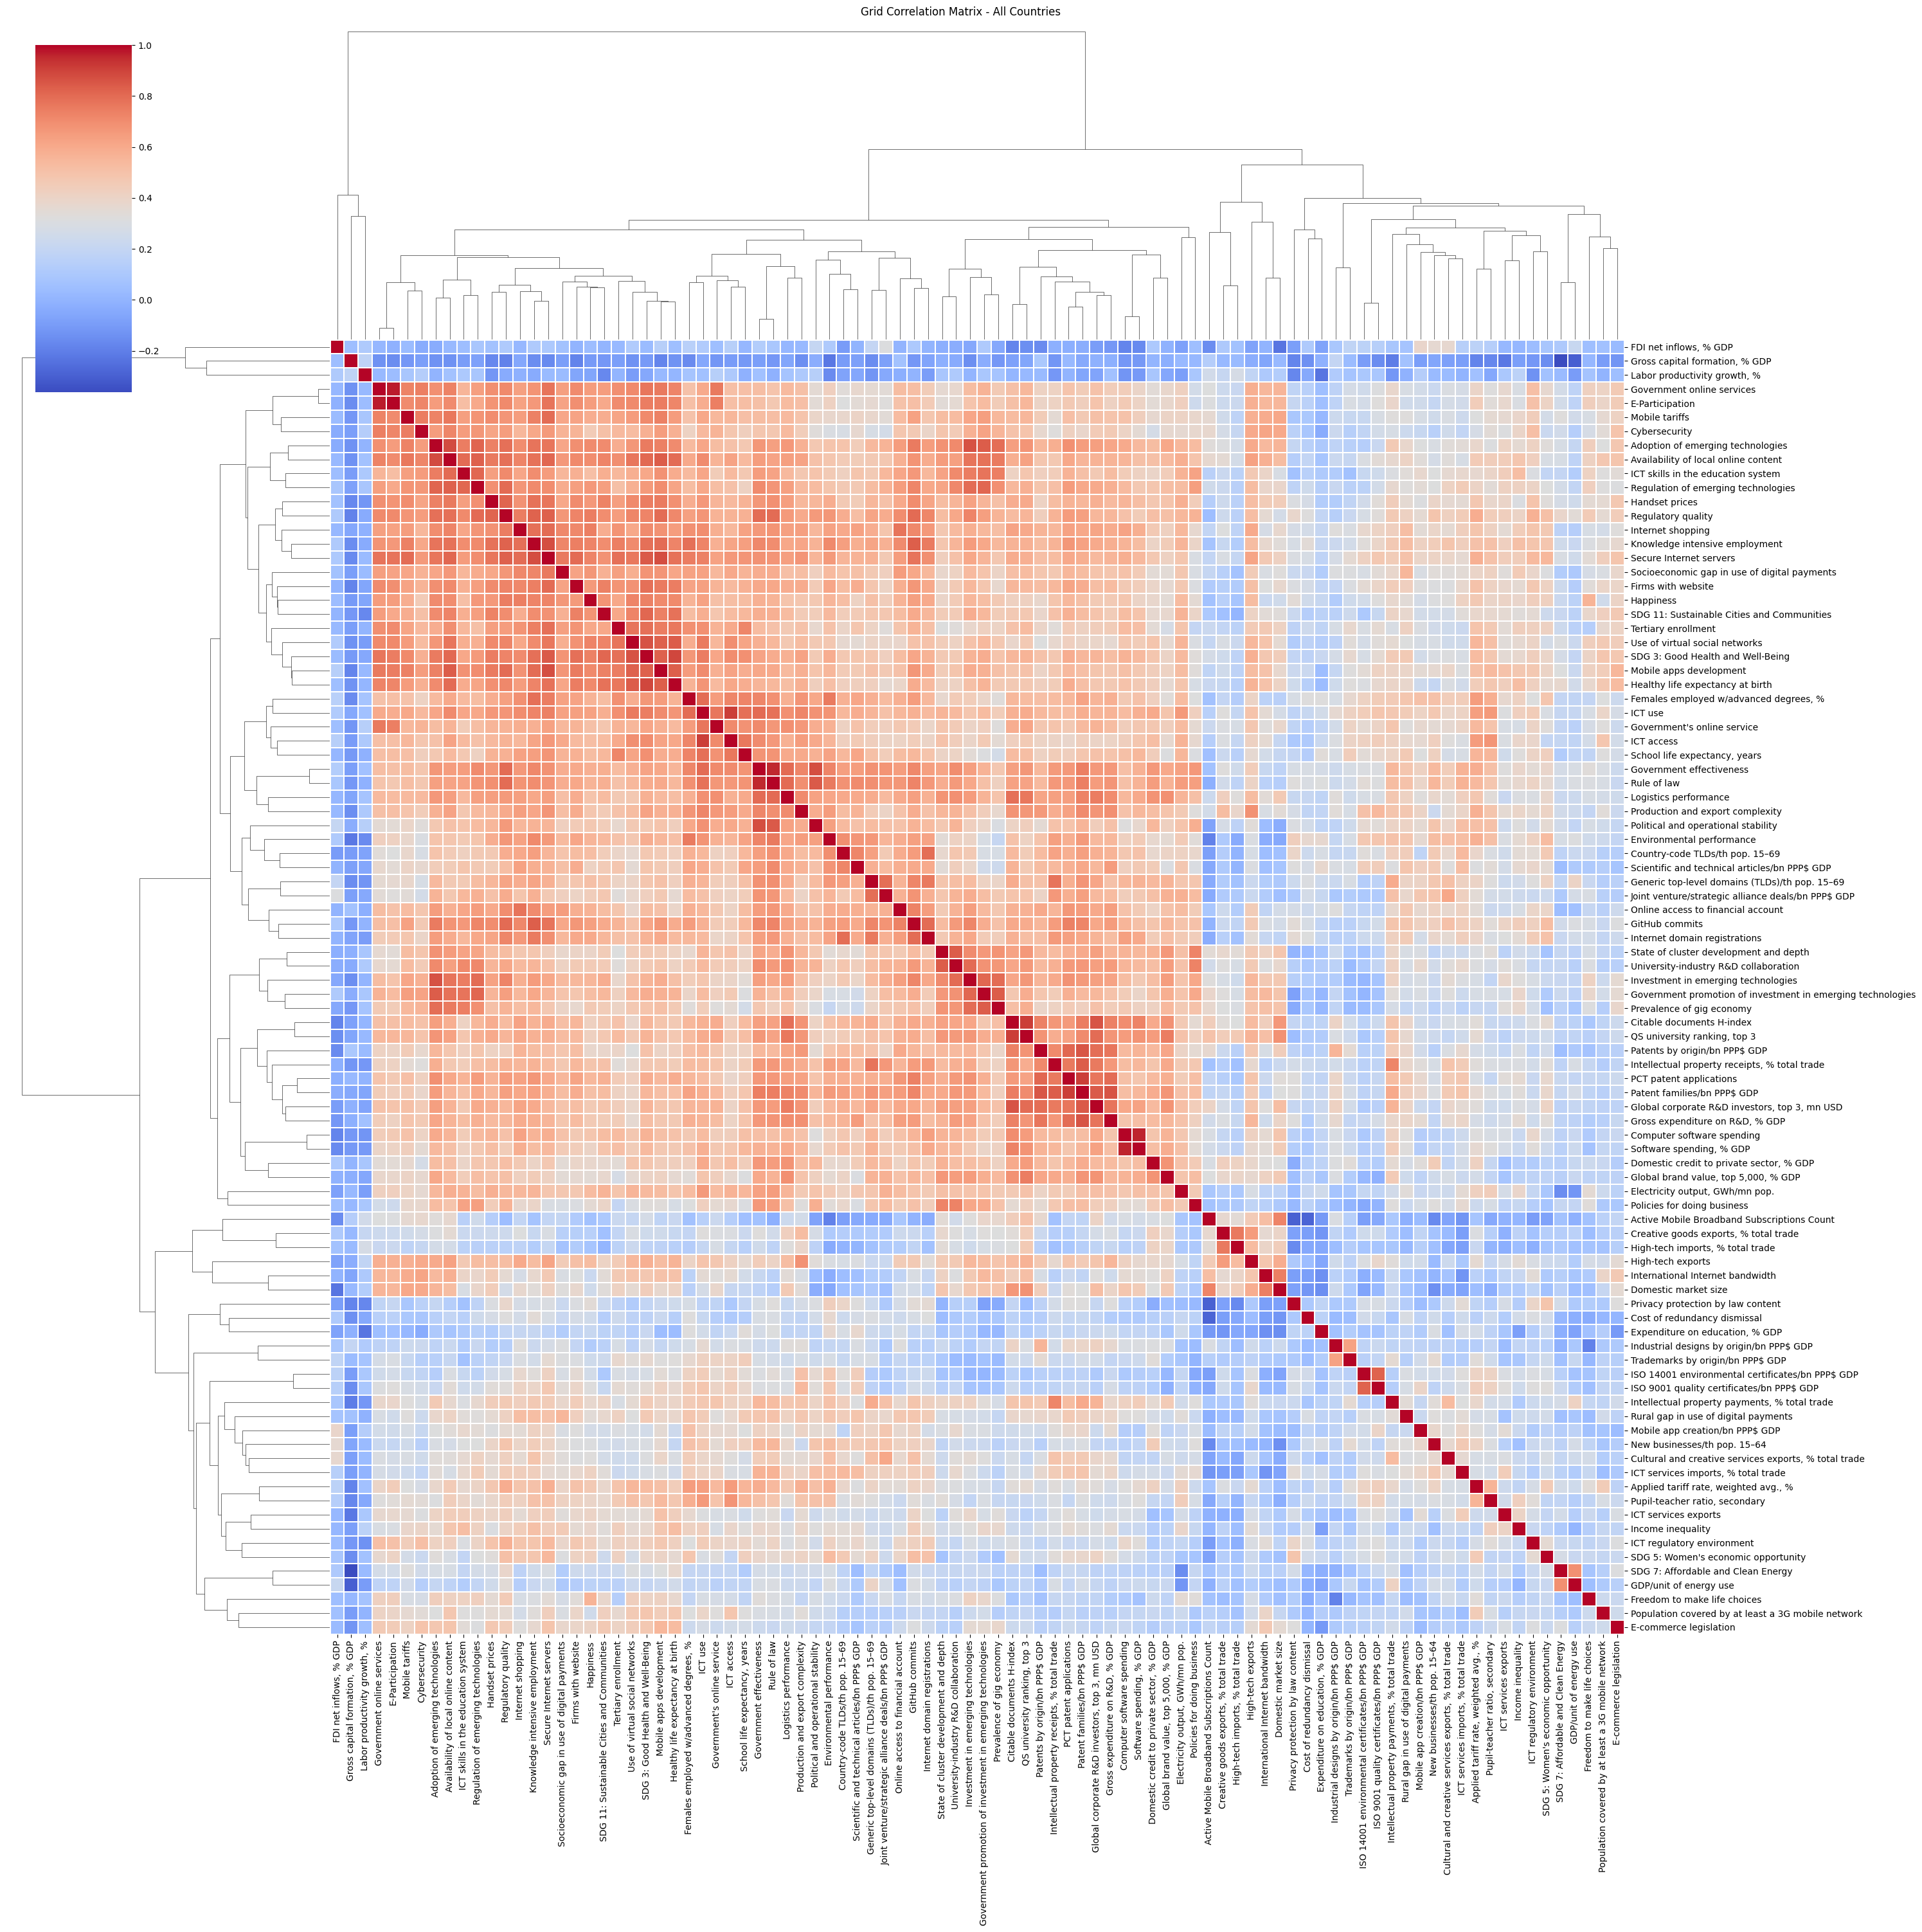

In [48]:
Tit = "Grid Correlation Matrix - All Countries"

corrmat = Indicators2.corr()
cg = sns.clustermap(corrmat, cmap ="coolwarm", figsize=(30, 30), linewidths = 0.1);
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)
plt.suptitle(Tit).set_y(1)
cg
# plt.savefig("CorrelationMatrix-All.png")

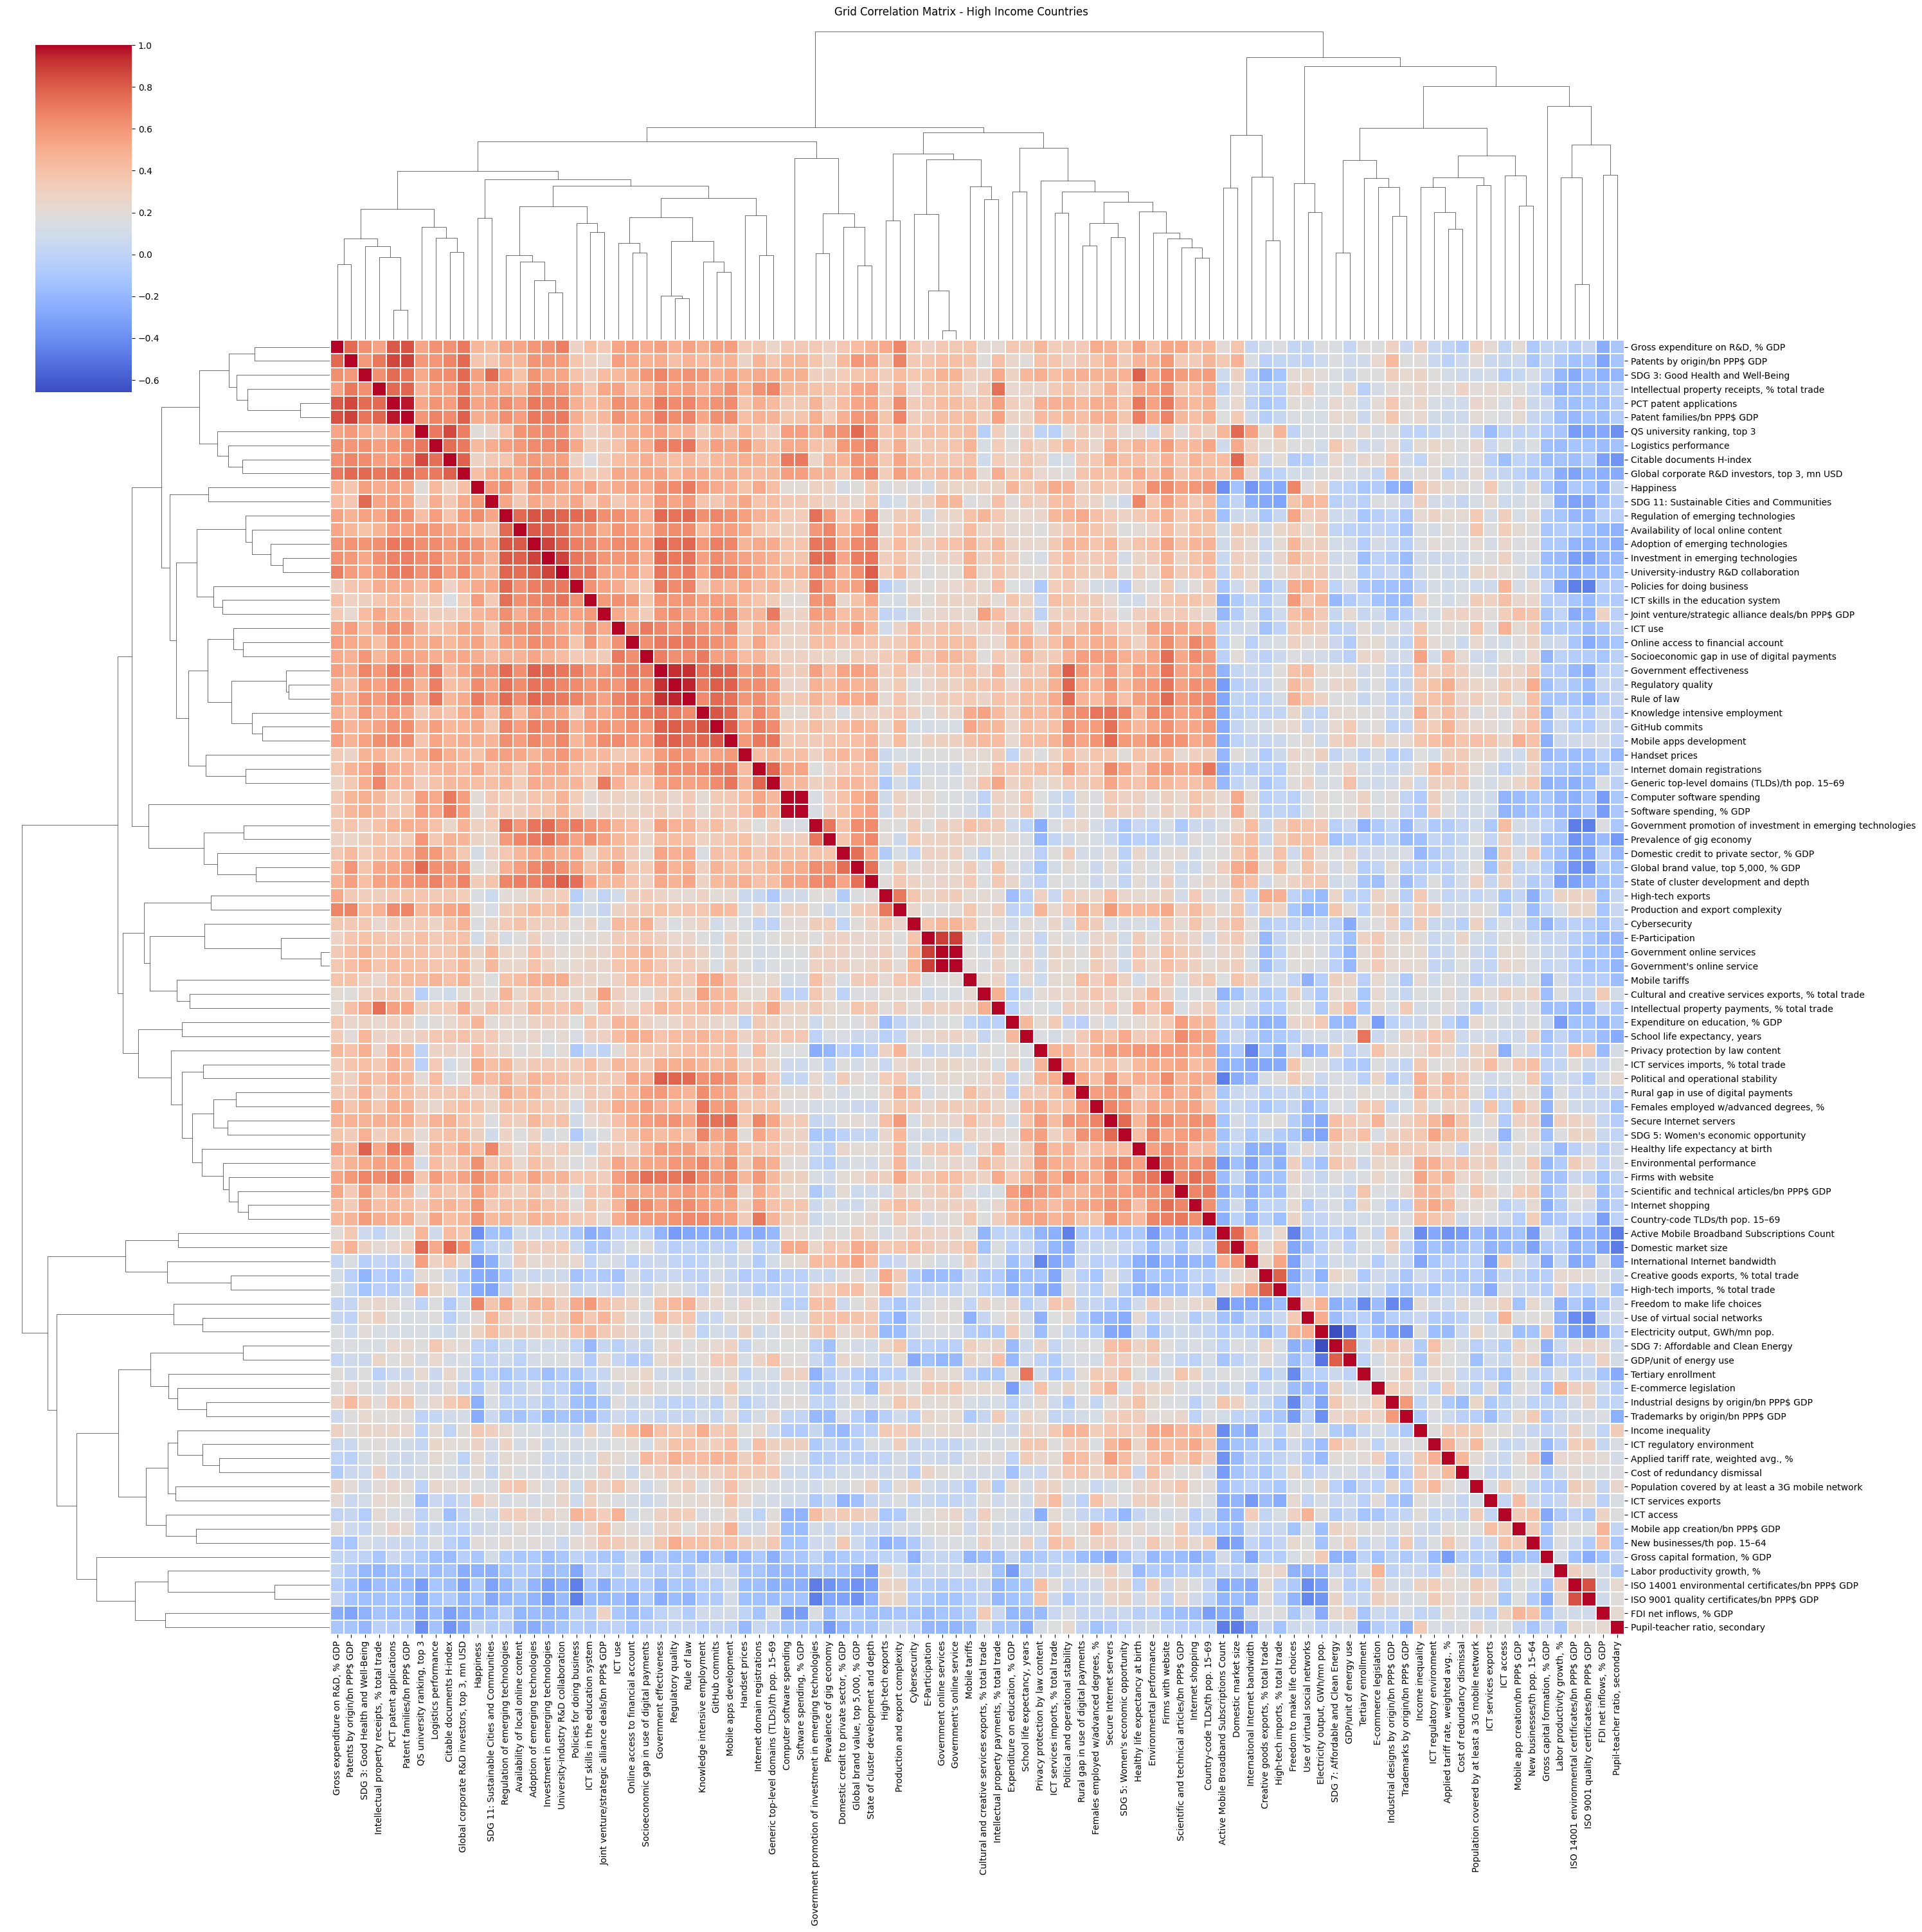

In [49]:
IndicatorsHigh = Master[Master['Cluster'] == 2].iloc[:,14:106] # Change the dataset for each cluster!
TitHigh = "Grid Correlation Matrix - High Income Countries"

corrmatHigh = IndicatorsHigh.corr()
cgHigh = sns.clustermap(corrmatHigh, cmap ="coolwarm", figsize=(30, 30), linewidths = 0.1);
plt.setp(cgHigh.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)
plt.suptitle(TitHigh).set_y(1)
cgHigh
# plt.savefig("CorrelationMatrix-High.png")

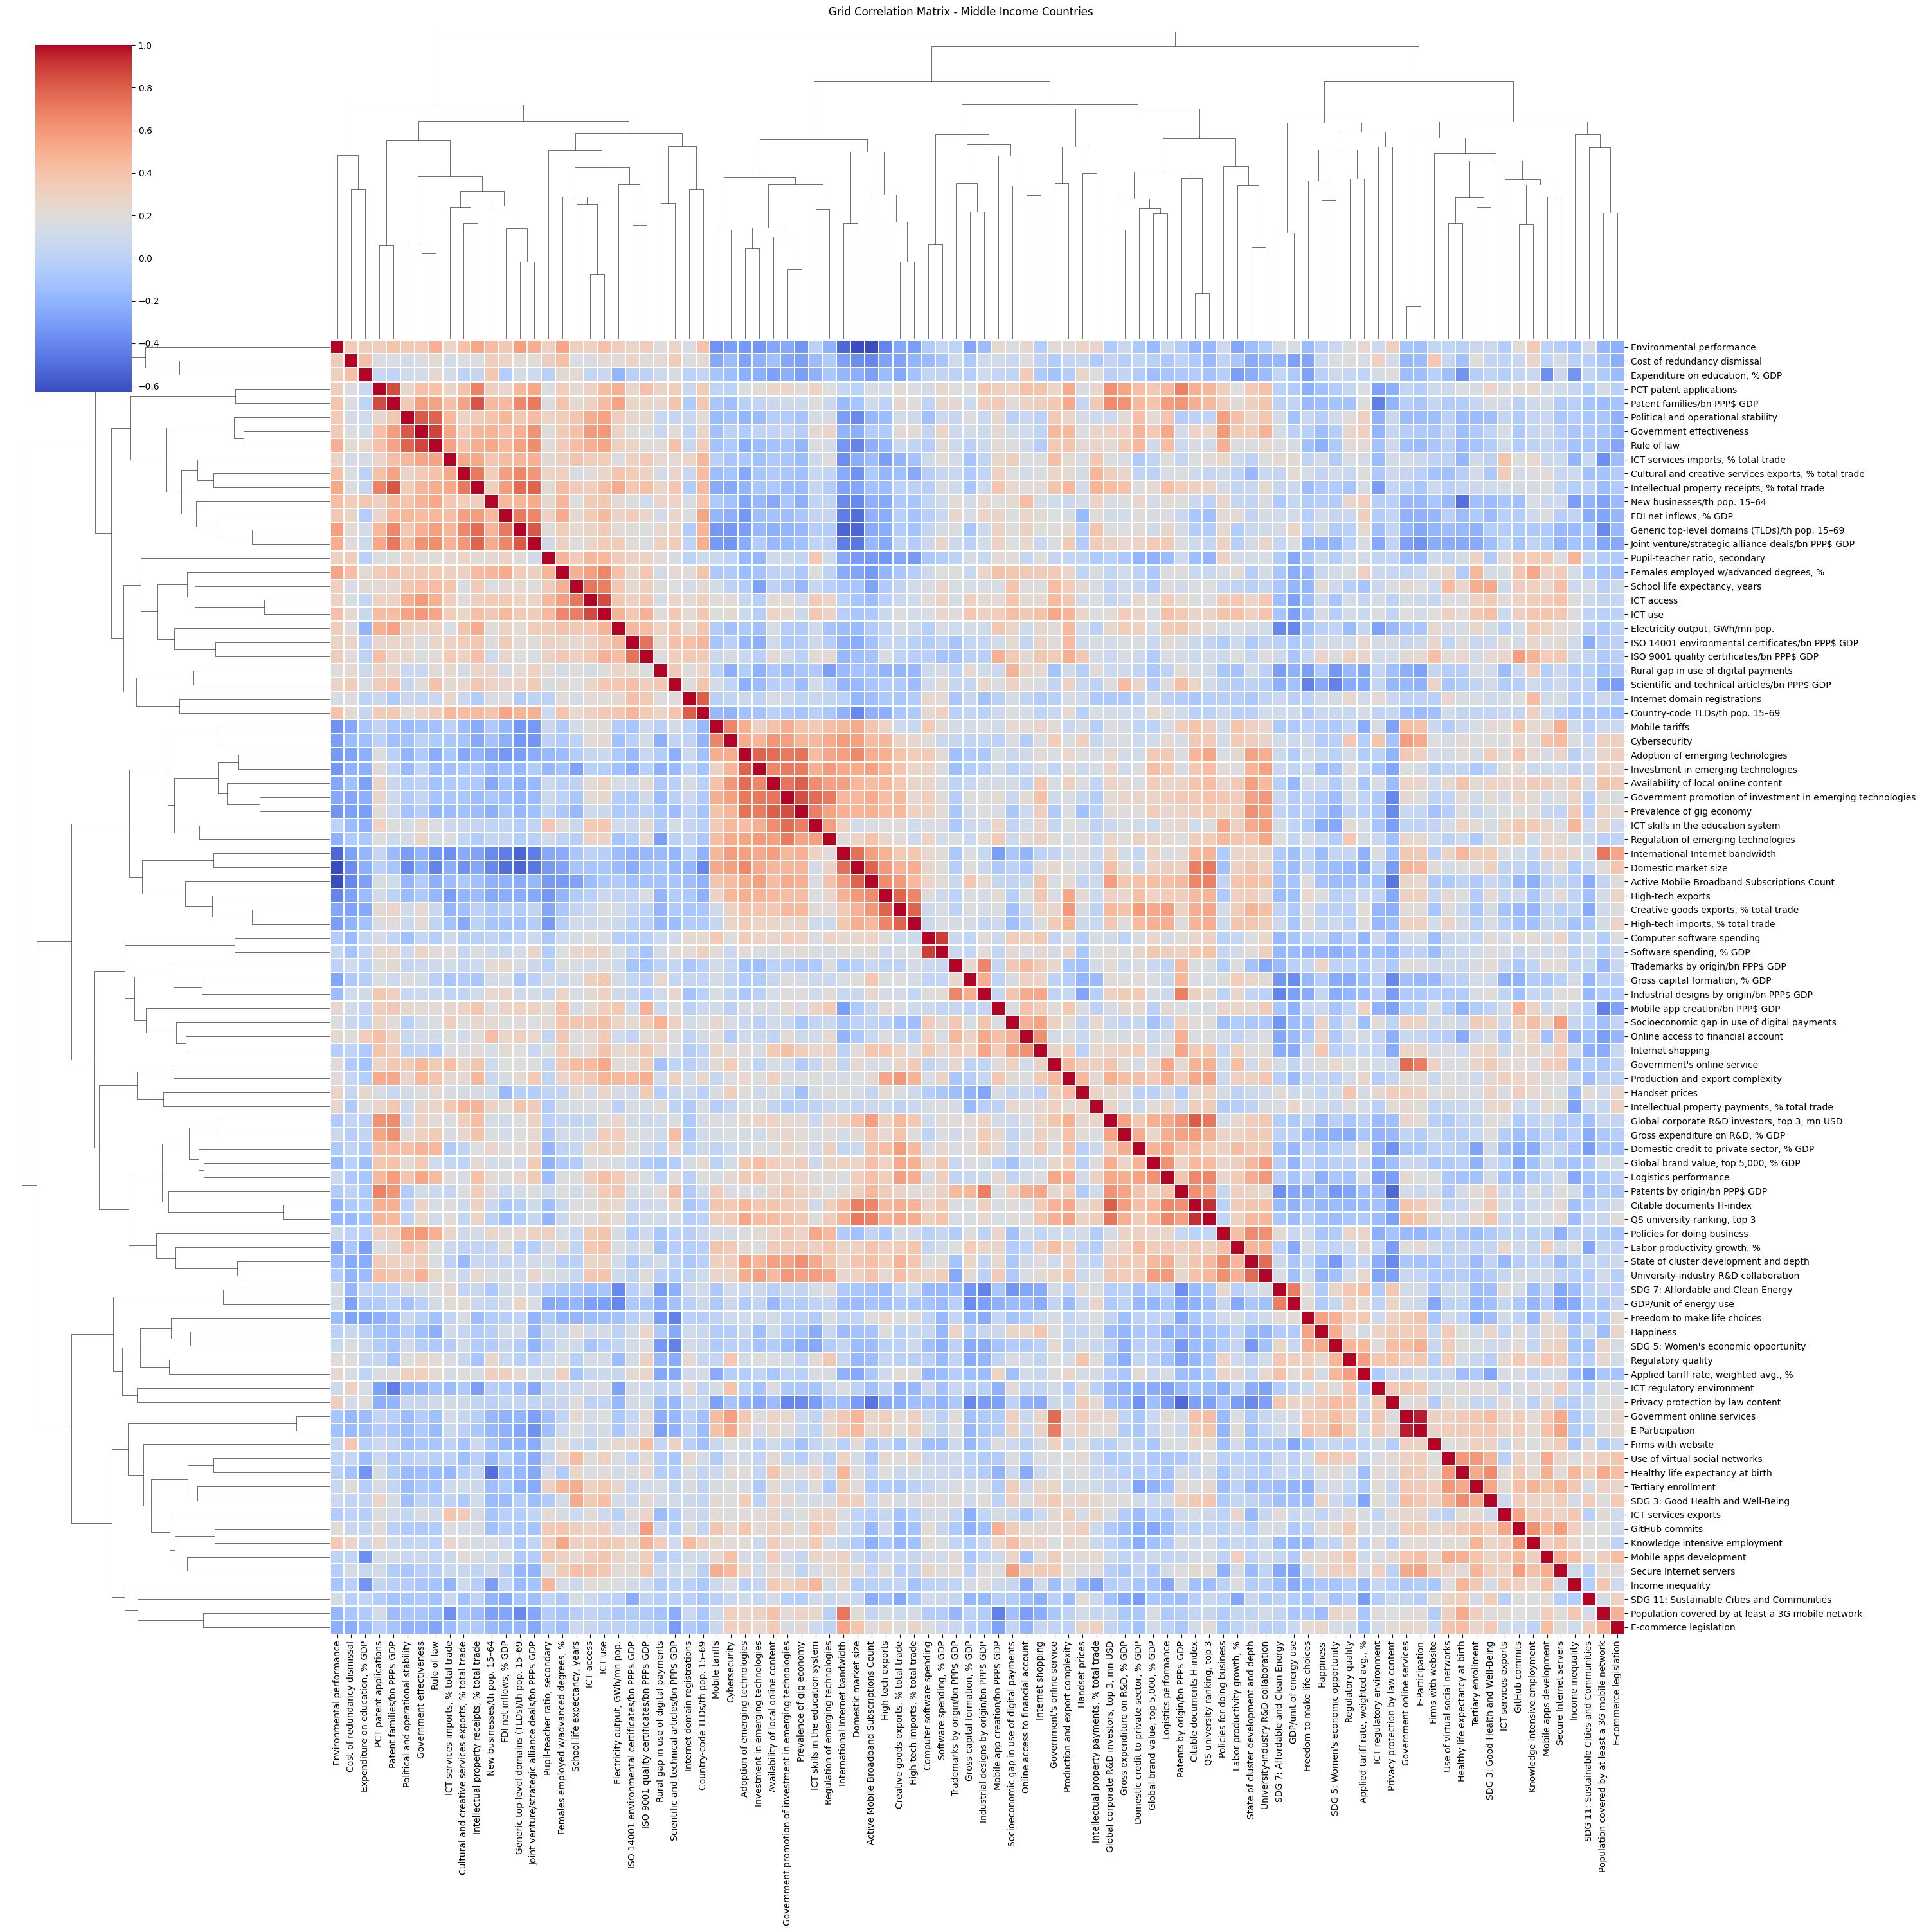

In [50]:
IndicatorsMid = Master[Master['Cluster'] == 0].iloc[:,14:106] # Change the dataset for each cluster!
TitMid = "Grid Correlation Matrix - Middle Income Countries"

corrmatMid = IndicatorsMid.corr()
cgMid = sns.clustermap(corrmatMid, cmap ="coolwarm", figsize=(30, 30), linewidths = 0.1);
plt.setp(cgMid.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)
plt.suptitle(TitMid).set_y(1)
cgMid
# plt.savefig("CorrelationMatrix-Mid.png")

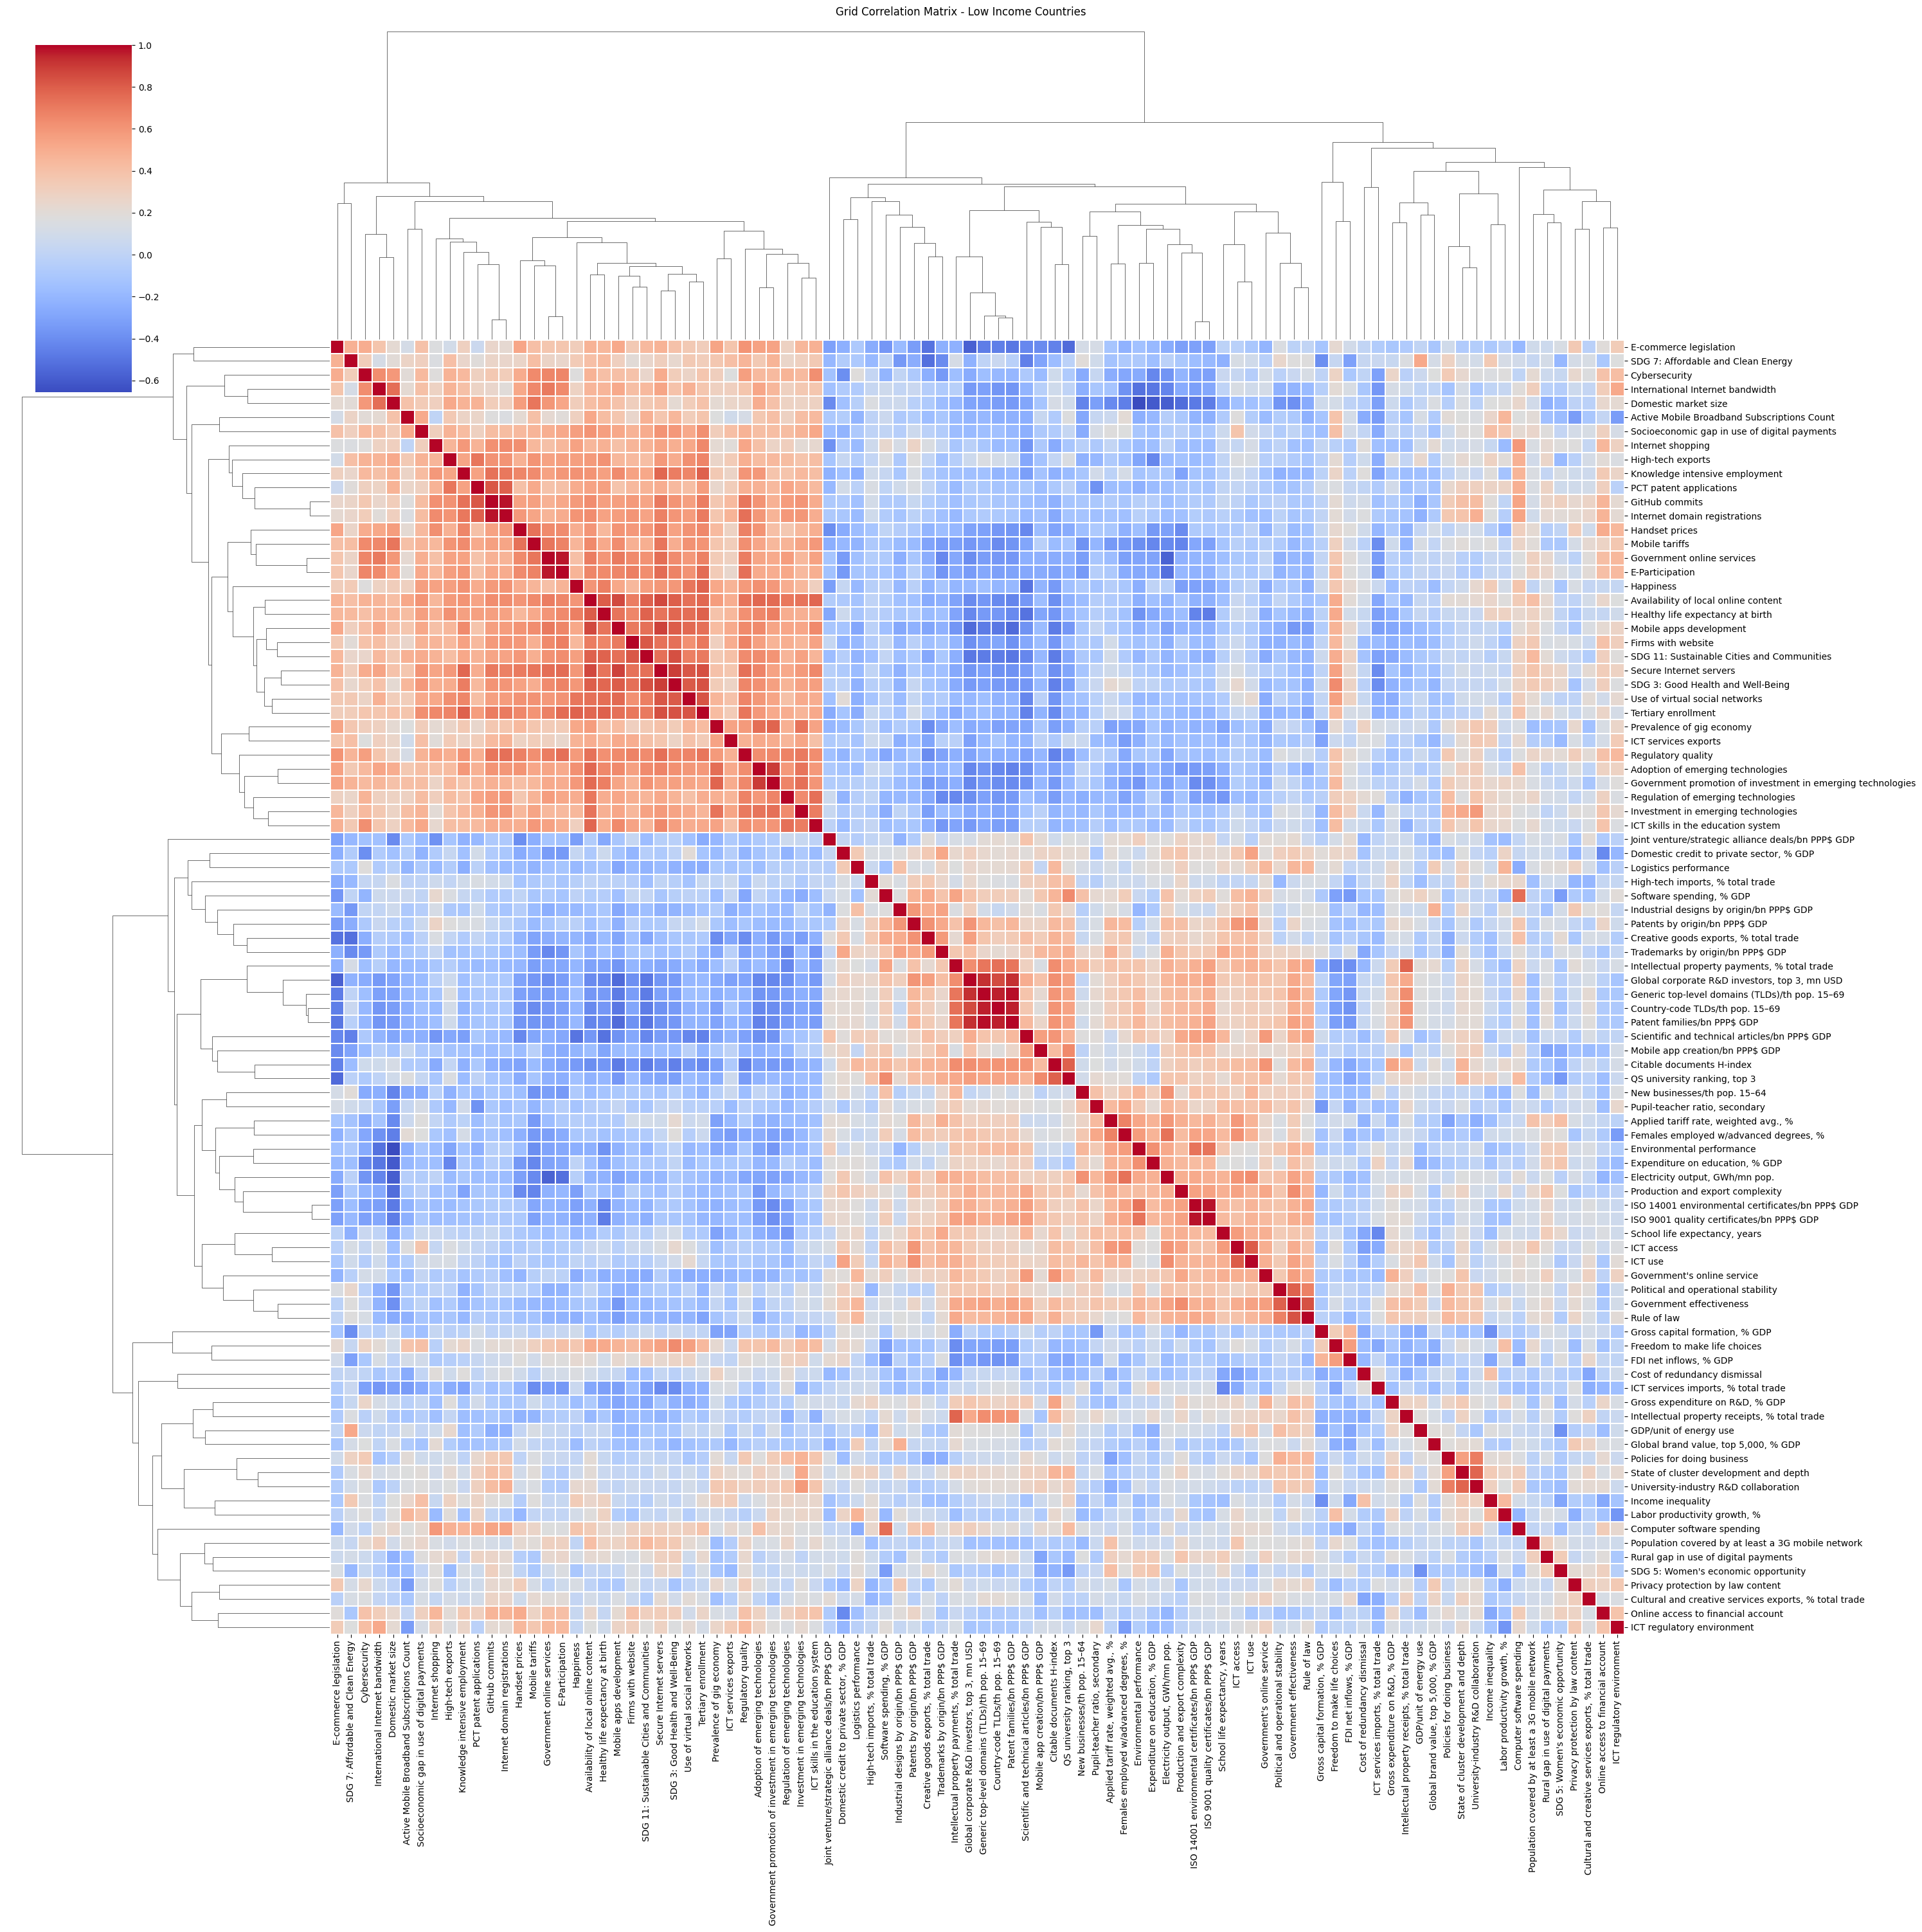

In [51]:
IndicatorsLow = Master[Master['Cluster'] == 1].iloc[:,14:106] # Change the dataset for each cluster!
TitLow = 'Grid Correlation Matrix - Low Income Countries'

corrmatLow = IndicatorsLow.corr()
cgLow = sns.clustermap(corrmatLow, cmap ="coolwarm", figsize=(30, 30), linewidths = 0.1);
plt.setp(cgLow.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)
plt.suptitle(TitLow).set_y(1)
cgLow
# plt.savefig("CorrelationMatrix-Low.png")

<a id="PCA"></a>
# Principal Components Analysis (PCA)

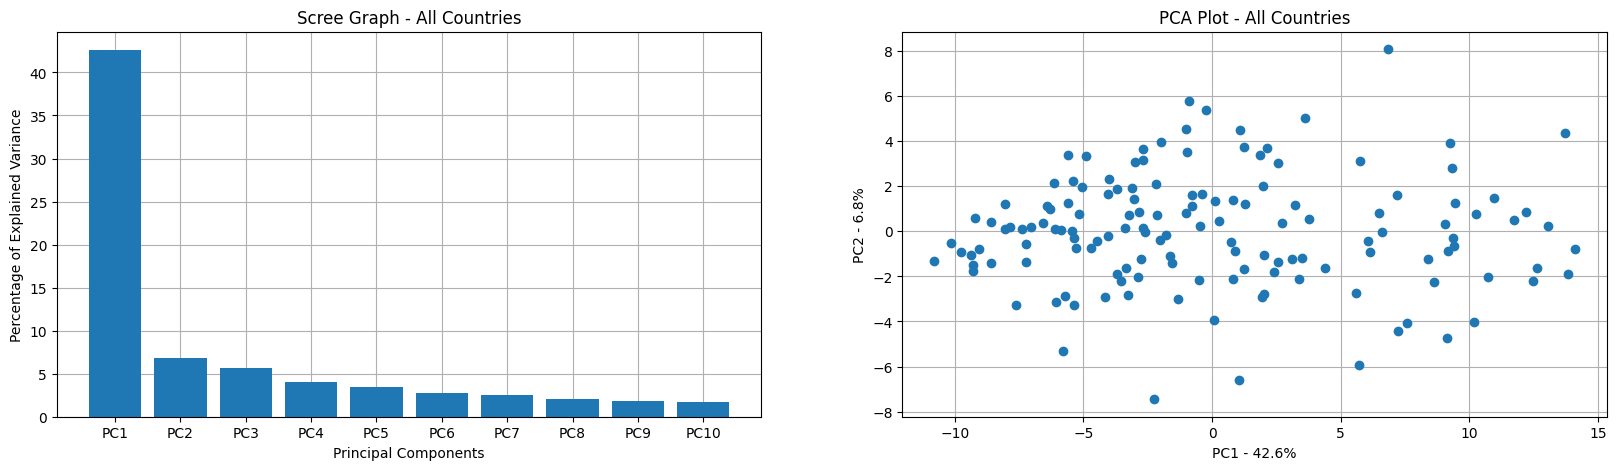

      % of Explained Variance
PC1                      42.6
PC2                       6.8
PC3                       5.7
PC4                       4.0
PC5                       3.4
PC6                       2.8
PC7                       2.5
PC8                       2.1
PC9                       1.8
PC10                      1.7
Total Explained PC1 to PC3: 55.1
Total Explained PC1 to PC5: 62.5
Total Explained PC1 to PC10: 73.4

 Top 10 Indicators of PC 1 for All Countries 
Secure Internet servers                 0.142
Regulatory quality                      0.141
Knowledge intensive employment          0.141
Availability of local online content    0.139
Government effectiveness                0.138
Adoption of emerging technologies       0.137
Rule of law                             0.136
ICT use                                 0.135
Internet shopping                       0.134
SDG 3: Good Health and Well-Being       0.134
dtype: float64
 Top 10 Indicators of PC 2 for All Countries 
Do

In [52]:
# Perform PCA on the indicators of all countries.

# Create a data frame with only the last imputed indicators for this cluster.
countries = 'All Countries'# Change the dataset for each cluster!

# First center and scale the data
scaled_data = preprocessing.scale(Indicators2) # Change the dataset for each cluster!
# Create Principal Component Analysis object and perform PCA
pca = PCA(10) # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for scaled_data

# Construct the plots:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)
ax1.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
ax1.set_ylabel('Percentage of Explained Variance')
ax1.set_xlabel('Principal Components')
ax1.set_title('Scree Graph - {0}'.format(countries))
ax1.set_axisbelow(True)
ax1.grid()
# Plot using PC1 and PC2
pca_df = pd.DataFrame(pca_data, columns=labels)
ax2.scatter(pca_df.PC1, pca_df.PC2)
ax2.set_title('PCA Plot - {0}'.format(countries))
ax2.set_xlabel('PC1 - {0}%'.format(per_var[0]))
ax2.set_ylabel('PC2 - {0}%'.format(per_var[1]))
ax2.set_axisbelow(True)
ax2.grid()
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample])) # Labels for each data point
plt.show() 

# Summarize variances of the 10 principal components
pc_var = dict(zip(labels, per_var))
PC_Variances = pd.DataFrame.from_dict(pc_var, columns=['% of Explained Variance'], orient ='index')
print(PC_Variances.head(10))
print('Total Explained PC1 to PC3:',round(PC_Variances.head(3).sum().sum(),1))
print('Total Explained PC1 to PC5:',round(PC_Variances.head(5).sum().sum(),1))
print('Total Explained PC1 to PC10:',round(PC_Variances.head(10).sum().sum(),1))
print('')

# Name of the top indicators that contribute most to PC1 i.e.: pca.components_[0].
for p in range(0,3):
    loading_scores = pd.Series(np.round(pca.components_[p], 3), index=Indicators2.columns) # get the loading scores
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False) # sort the loading scores based on their magnitude
    top_ind = sorted_loading_scores[0:10].index.values # get the names of the top indicators
    print('\033[1m','Top 10 Indicators of PC', p+1, 'for', countries, '\033[0m')
    print(loading_scores[top_ind]) # print the indicators' names and their scores (and +/- sign)

pc1_loading_scores = pd.Series(np.round(pca.components_[0], 3), index=Indicators2.columns) # get the loading scores of PC1!
loading_scores_All = pd.DataFrame(pc1_loading_scores,columns=['{0}'.format(countries)]) # Create a df with the scores of PC1!

From the previous plots, it is evident that the most significant variance is found in PC1.\
However, to test this project's hypothesis, the Principal Components could be different across clusters as follows.

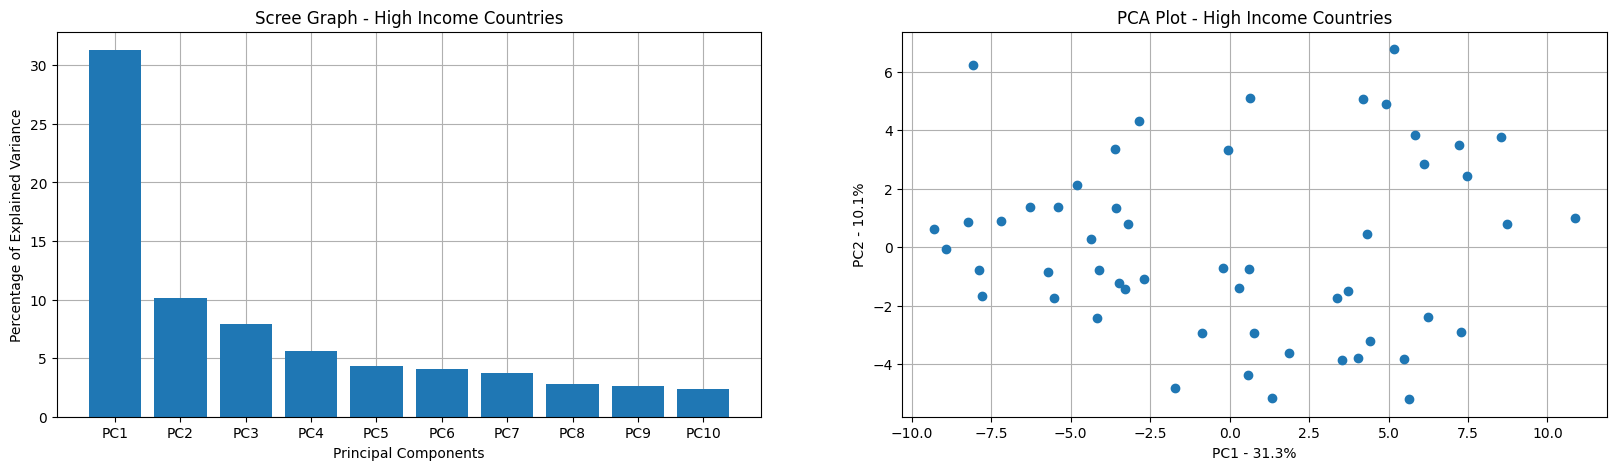

      % of Explained Variance
PC1                      31.3
PC2                      10.1
PC3                       7.9
PC4                       5.6
PC5                       4.3
PC6                       4.1
PC7                       3.7
PC8                       2.8
PC9                       2.6
PC10                      2.4
Total Explained PC1 to PC3: 49.3
Total Explained PC1 to PC5: 59.2
Total Explained PC1 to PC10: 74.8

 Top 10 Indicators of PC 1 for High Income Countries 
Government effectiveness              -0.167
Rule of law                           -0.164
Regulatory quality                    -0.161
Adoption of emerging technologies     -0.158
Mobile apps development               -0.157
Patent families/bn PPP$ GDP           -0.156
PCT patent applications               -0.156
GitHub commits                        -0.152
Investment in emerging technologies   -0.149
Firms with website                    -0.148
dtype: float64
 Top 10 Indicators of PC 2 for High Income Countri

In [53]:
# Perform PCA on the indicators of high-income countries (Cluster: 2).

# Create a data frame with only the last imputed indicators for this cluster.
countries = 'High Income Countries'# Change the dataset for each cluster!

# First center and scale the data
scaled_data = preprocessing.scale(IndicatorsHigh) # Change the dataset for each cluster!
pca = PCA(10) # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for scaled_data

# Construct the plots:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)
ax1.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
ax1.set_ylabel('Percentage of Explained Variance')
ax1.set_xlabel('Principal Components')
ax1.set_title('Scree Graph - {0}'.format(countries))
ax1.set_axisbelow(True)
ax1.grid()
# Plot using PC1 and PC2
pca_df = pd.DataFrame(pca_data, columns=labels)
ax2.scatter(pca_df.PC1, pca_df.PC2)
ax2.set_title('PCA Plot - {0}'.format(countries))
ax2.set_xlabel('PC1 - {0}%'.format(per_var[0]))
ax2.set_ylabel('PC2 - {0}%'.format(per_var[1]))
ax2.set_axisbelow(True)
ax2.grid()
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample])) # Labels for each data point
plt.show() 

# Summarize variances of the 10 principal components
pc_var = dict(zip(labels, per_var))
PC_Variances = pd.DataFrame.from_dict(pc_var, columns=['% of Explained Variance'], orient ='index')
print(PC_Variances.head(10))
print('Total Explained PC1 to PC3:',round(PC_Variances.head(3).sum().sum(), 1))
print('Total Explained PC1 to PC5:',round(PC_Variances.head(5).sum().sum(), 1))
print('Total Explained PC1 to PC10:',round(PC_Variances.head(10).sum().sum(), 1))
print('')

# Name of the top indicators that contribute most to PC1 i.e.: pca.components_[0].
for p in range(0,3):
    loading_scores = pd.Series(np.round(pca.components_[p], 3), index=Indicators2.columns) # get the loading scores
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False) # sort the loading scores based on their magnitude
    top_ind = sorted_loading_scores[0:10].index.values # get the names of the top indicators
    print('\033[1m','Top 10 Indicators of PC', p+1, 'for', countries, '\033[0m')
    print(loading_scores[top_ind]) # print the indicators' names and their scores (and +/- sign)

pc1_loading_scores = pd.Series(np.round(pca.components_[0], 3), index=Indicators2.columns) # get the loading scores of PC1!
loading_scores_High = pd.DataFrame(pc1_loading_scores,columns=['{0}'.format(countries)]) # Create a df with the scores of PC1!

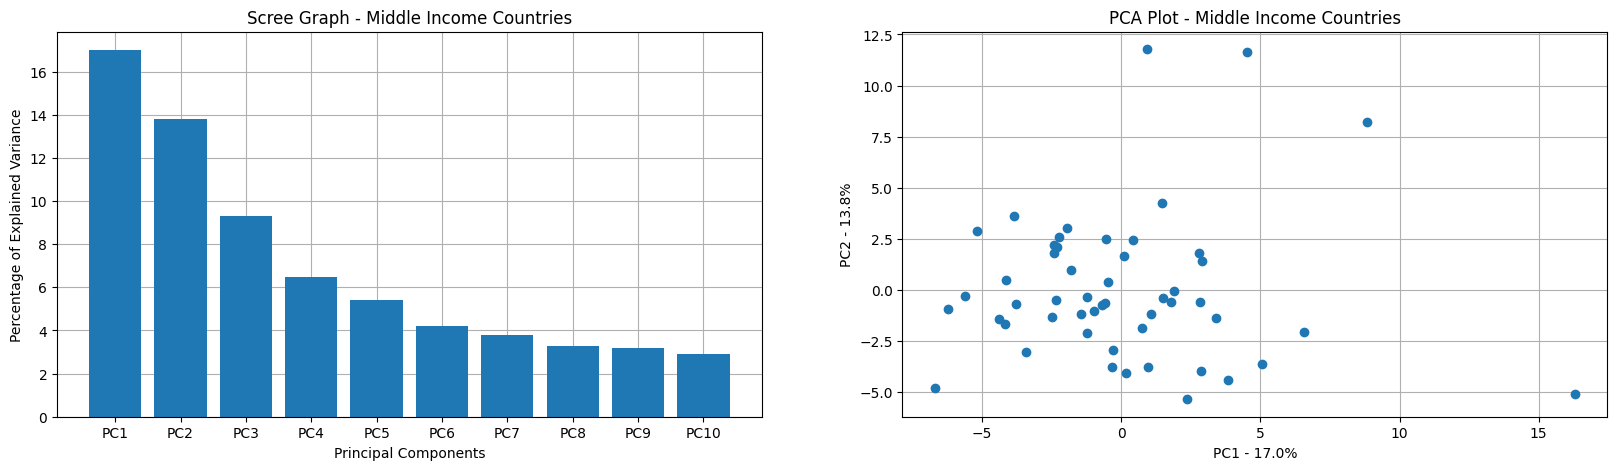

      % of Explained Variance
PC1                      17.0
PC2                      13.8
PC3                       9.3
PC4                       6.5
PC5                       5.4
PC6                       4.2
PC7                       3.8
PC8                       3.3
PC9                       3.2
PC10                      2.9
Total Explained PC1 to PC3: 40.1
Total Explained PC1 to PC5: 52.0
Total Explained PC1 to PC10: 69.4

 Top 10 Indicators of PC 1 for Middle Income Countries 
QS university ranking, top 3                     0.186
Citable documents H-index                        0.184
ICT use                                          0.180
PCT patent applications                          0.177
Production and export complexity                 0.175
Logistics performance                            0.173
University-industry R&D collaboration            0.165
Patent families/bn PPP$ GDP                      0.165
Patents by origin/bn PPP$ GDP                    0.162
Global corporate R

In [54]:
# Perform PCA on the indicators of middle-income countries (Cluster: 0).

# Create a data frame with only the last imputed indicators for this cluster.
countries = 'Middle Income Countries'# Change the dataset for each cluster!

# First center and scale the data
scaled_data = preprocessing.scale(IndicatorsMid) # Change the dataset for each cluster!
pca = PCA(10) # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for scaled_data

# Construct the plots:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)
ax1.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
ax1.set_ylabel('Percentage of Explained Variance')
ax1.set_xlabel('Principal Components')
ax1.set_title('Scree Graph - {0}'.format(countries))
ax1.set_axisbelow(True)
ax1.grid()
# Plot using PC1 and PC2
pca_df = pd.DataFrame(pca_data, columns=labels)
ax2.scatter(pca_df.PC1, pca_df.PC2)
ax2.set_title('PCA Plot - {0}'.format(countries))
ax2.set_xlabel('PC1 - {0}%'.format(per_var[0]))
ax2.set_ylabel('PC2 - {0}%'.format(per_var[1]))
ax2.set_axisbelow(True)
ax2.grid()
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample])) # Labels for each data point
plt.show() 

# Summarize variances of the 10 principal components
pc_var = dict(zip(labels, per_var))
PC_Variances = pd.DataFrame.from_dict(pc_var, columns=['% of Explained Variance'], orient ='index')
print(PC_Variances.head(10))
print('Total Explained PC1 to PC3:',round(PC_Variances.head(3).sum().sum(), 1))
print('Total Explained PC1 to PC5:',round(PC_Variances.head(5).sum().sum(), 1))
print('Total Explained PC1 to PC10:',round(PC_Variances.head(10).sum().sum(), 1))
print('')

# Name of the top indicators that contribute most to PC1 i.e.: pca.components_[0].
for p in range(0,3):
    loading_scores = pd.Series(np.round(pca.components_[p], 3), index=Indicators2.columns) # get the loading scores
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False) # sort the loading scores based on their magnitude
    top_ind = sorted_loading_scores[0:10].index.values # get the names of the top indicators
    print('\033[1m','Top 10 Indicators of PC', p+1, 'for', countries, '\033[0m')
    print(loading_scores[top_ind]) # print the indicators' names and their scores (and +/- sign)

pc1_loading_scores = pd.Series(np.round(pca.components_[0], 3), index=Indicators2.columns) # get the loading scores of PC1!
loading_scores_Mid = pd.DataFrame(pc1_loading_scores,columns=['{0}'.format(countries)]) # Create a df with the scores of PC1!

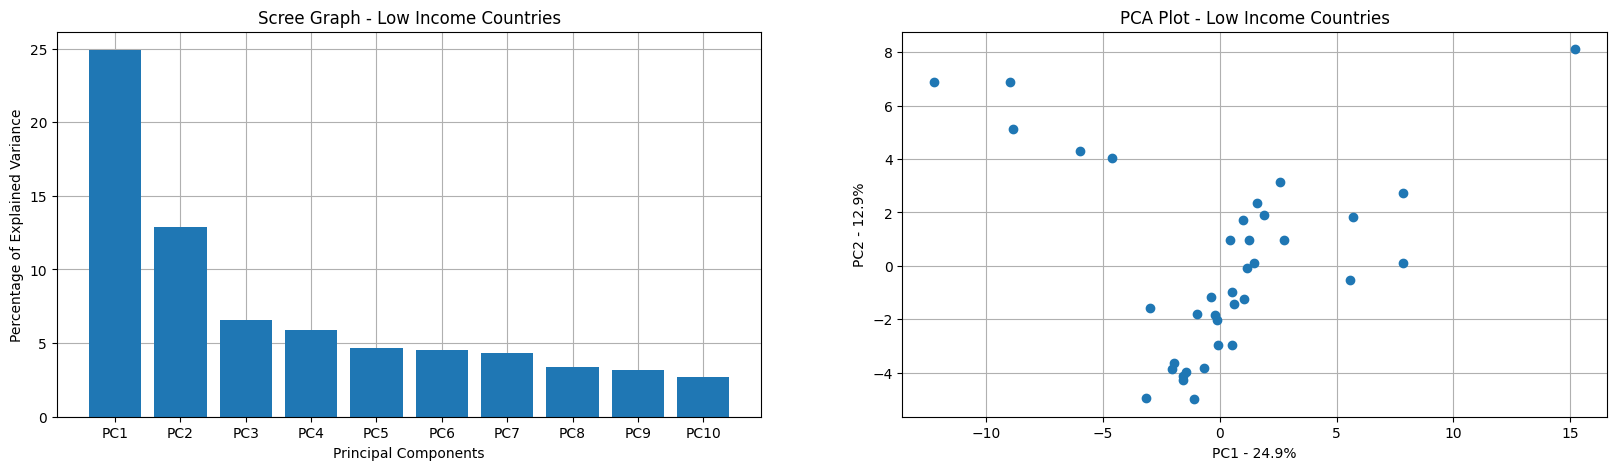

      % of Explained Variance
PC1                      24.9
PC2                      12.9
PC3                       6.6
PC4                       5.9
PC5                       4.7
PC6                       4.5
PC7                       4.3
PC8                       3.4
PC9                       3.2
PC10                      2.7
Total Explained PC1 to PC3: 44.4
Total Explained PC1 to PC5: 55.0
Total Explained PC1 to PC10: 73.1

 Top 10 Indicators of PC 1 for Low Income Countries 
Availability of local online content    0.179
Mobile apps development                 0.175
Secure Internet servers                 0.173
Healthy life expectancy at birth        0.167
Adoption of emerging technologies       0.166
Tertiary enrollment                     0.165
Regulatory quality                      0.165
Government online services              0.164
E-Participation                         0.163
Mobile tariffs                          0.162
dtype: float64
 Top 10 Indicators of PC 2 for Low Income

In [55]:
# Perform PCA on the indicators of low-income countries (Cluster: 1).

# Create a data frame with only the last imputed indicators for this cluster.
countries = 'Low Income Countries'# Change the dataset for each cluster!

# First center and scale the data
scaled_data = preprocessing.scale(IndicatorsLow) # Change the dataset for each cluster!
pca = PCA(10) # create a PCA object
pca.fit(scaled_data) # do the math
pca_data = pca.transform(scaled_data) # get PCA coordinates for scaled_data

# Construct the plots:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)
ax1.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
ax1.set_ylabel('Percentage of Explained Variance')
ax1.set_xlabel('Principal Components')
ax1.set_title('Scree Graph - {0}'.format(countries))
ax1.set_axisbelow(True)
ax1.grid()
# Plot using PC1 and PC2
pca_df = pd.DataFrame(pca_data, columns=labels)
ax2.scatter(pca_df.PC1, pca_df.PC2)
ax2.set_title('PCA Plot - {0}'.format(countries))
ax2.set_xlabel('PC1 - {0}%'.format(per_var[0]))
ax2.set_ylabel('PC2 - {0}%'.format(per_var[1]))
ax2.set_axisbelow(True)
ax2.grid()
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample])) # Labels for each data point
plt.show() 

# Summarize variances of the 10 principal components
pc_var = dict(zip(labels, per_var))
PC_Variances = pd.DataFrame.from_dict(pc_var, columns=['% of Explained Variance'], orient ='index')
print(PC_Variances.head(10))
print('Total Explained PC1 to PC3:',round(PC_Variances.head(3).sum().sum(), 1))
print('Total Explained PC1 to PC5:',round(PC_Variances.head(5).sum().sum(), 1))
print('Total Explained PC1 to PC10:',round(PC_Variances.head(10).sum().sum(), 1))
print('')

# Name of the top indicators that contribute most to PC1 i.e.: pca.components_[0].
for p in range(0,3):
    loading_scores = pd.Series(np.round(pca.components_[p], 3), index=Indicators2.columns) # get the loading scores
    sorted_loading_scores = loading_scores.abs().sort_values(ascending=False) # sort the loading scores based on their magnitude
    top_ind = sorted_loading_scores[0:10].index.values # get the names of the top indicators
    print('\033[1m','Top 10 Indicators of PC', p+1, 'for', countries, '\033[0m')
    print(loading_scores[top_ind]) # print the indicators' names and their scores (and +/- sign)

pc1_loading_scores = pd.Series(np.round(pca.components_[0], 3), index=Indicators2.columns) # get the loading scores of PC1!
loading_scores_Low = pd.DataFrame(pc1_loading_scores,columns=['{0}'.format(countries)]) # Create a df with the scores of PC1!

<AxesSubplot: >

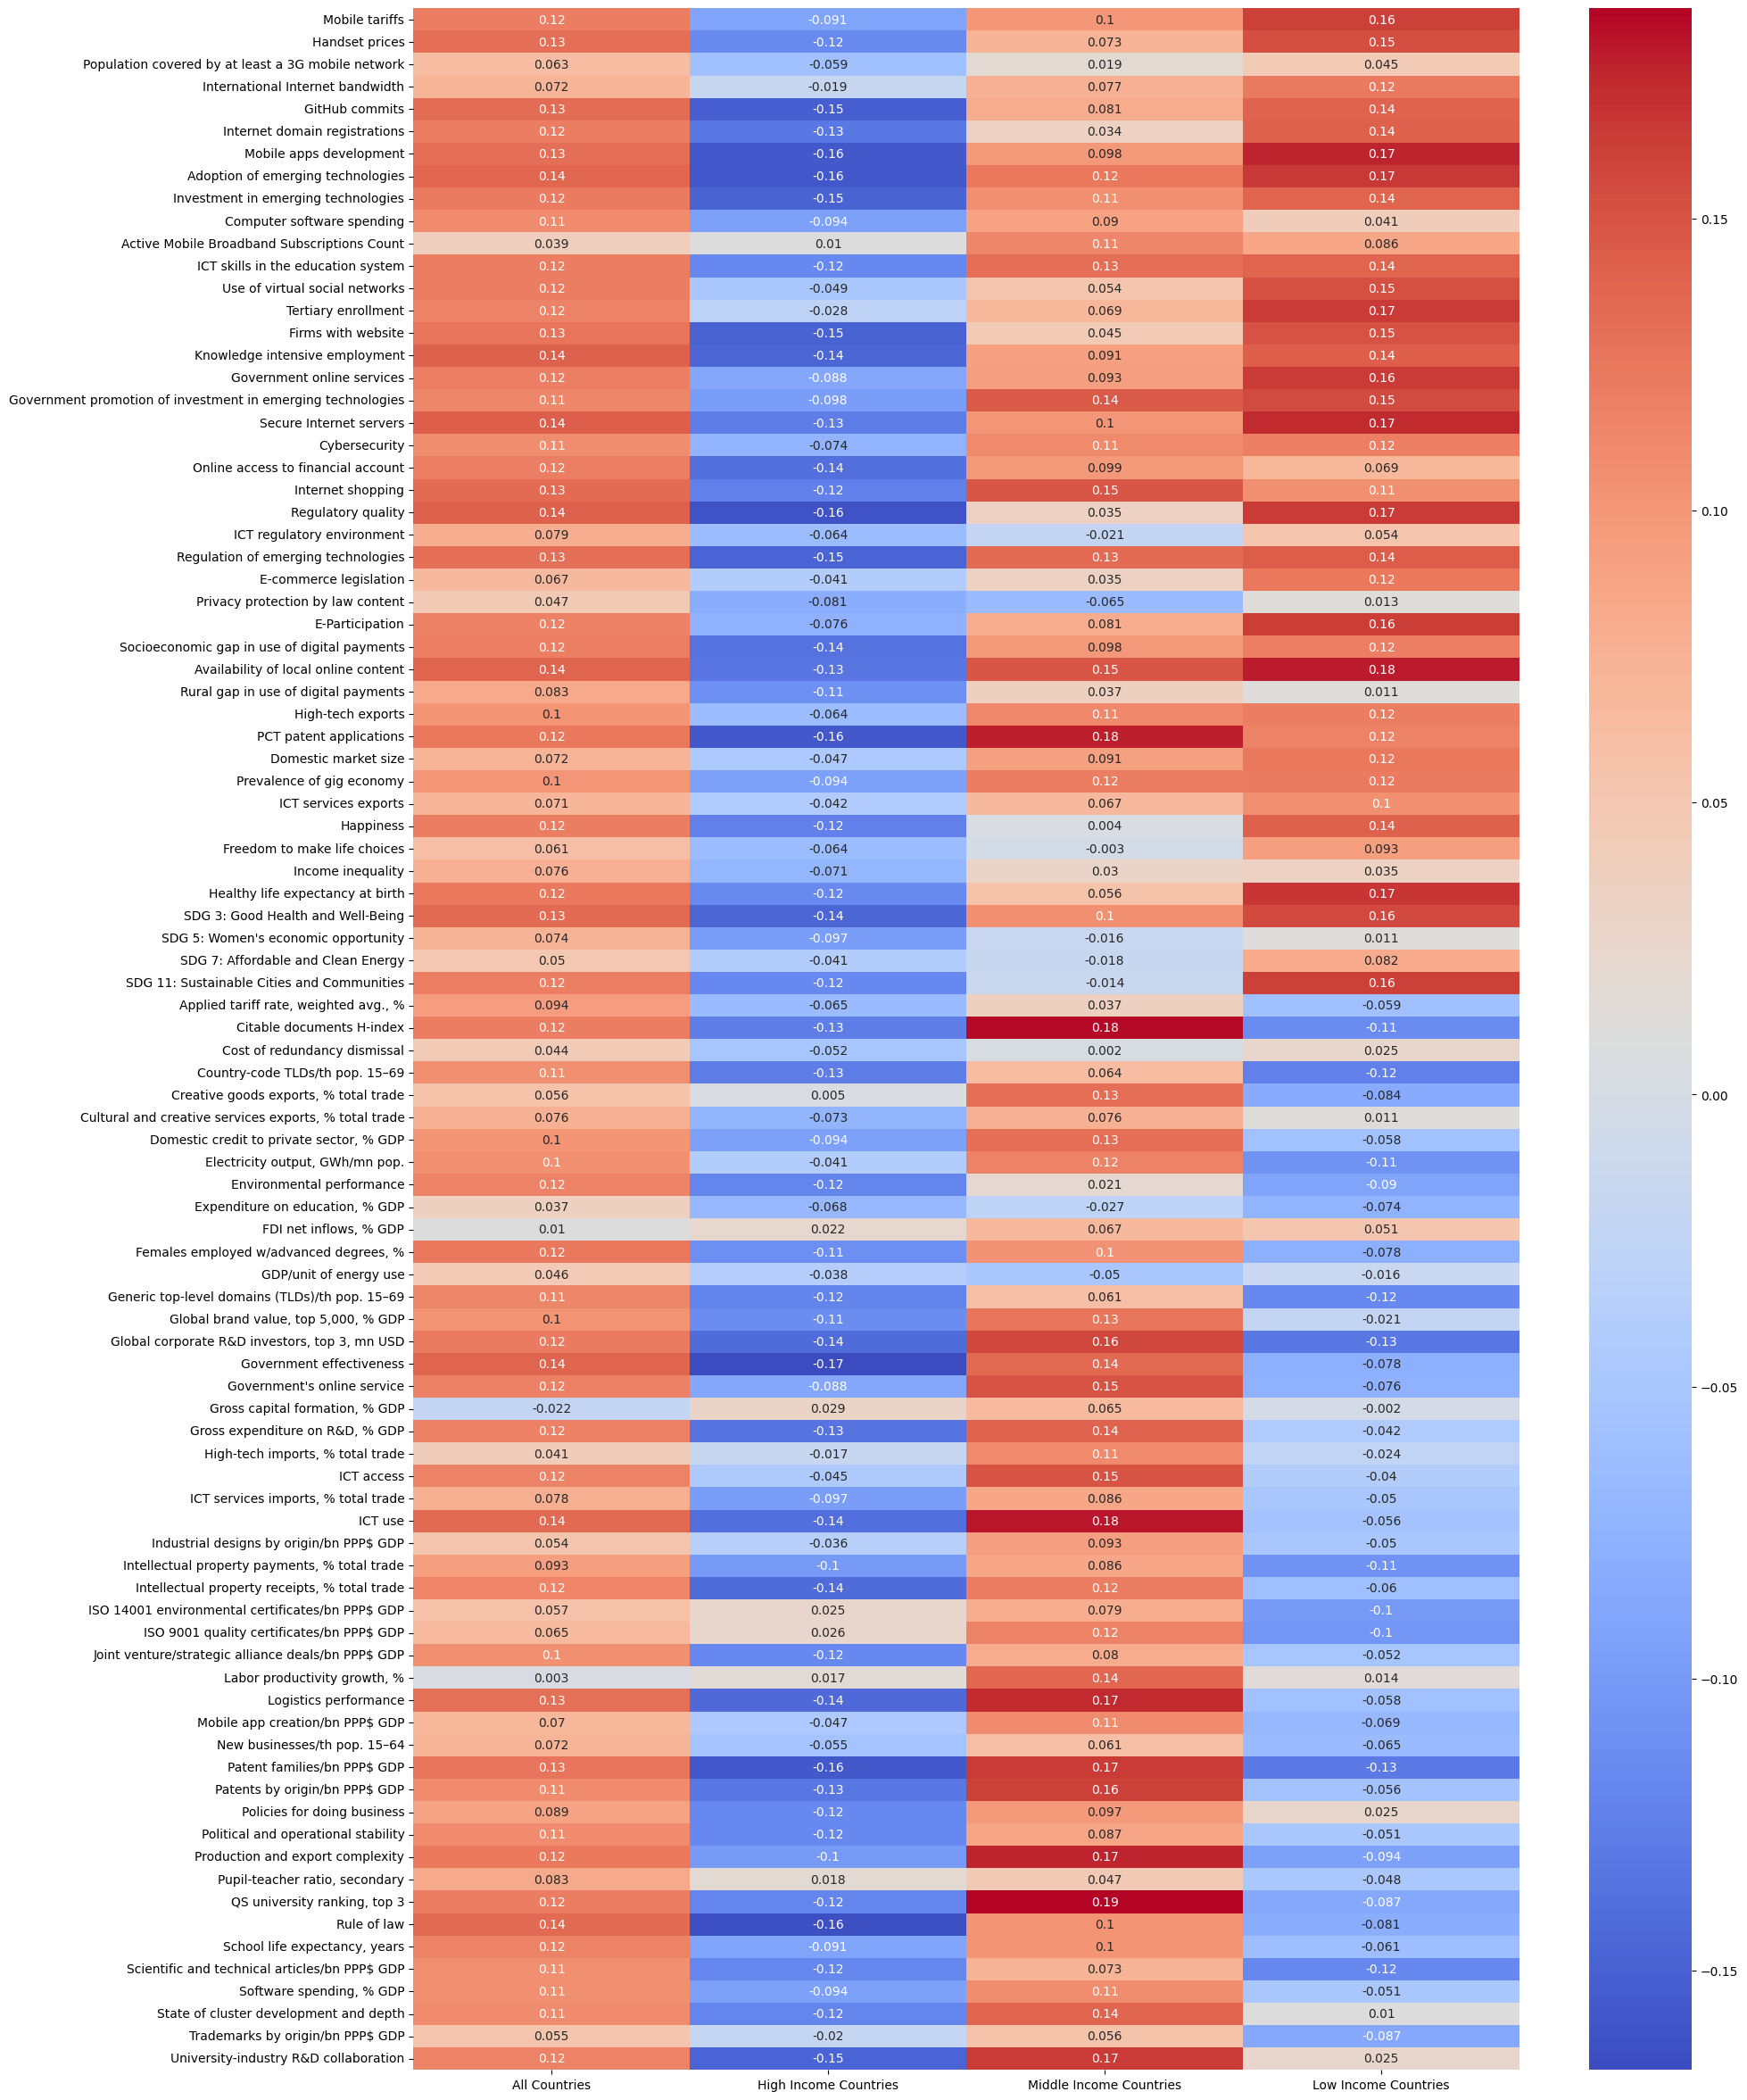

In [56]:
# Compare the variance scores of all indicators in PC1 across each cluster.
# Thus, realizing the principal components that preserve a “high” amount – positive (dark red) or negative (dark blue) of the cumulative variance of the original data.

MergeScores = loading_scores_All.join(
    loading_scores_High.set_index(loading_scores_High.index)[['High Income Countries']], on=loading_scores_All.index).join(
    loading_scores_Mid.set_index(loading_scores_Mid.index)[['Middle Income Countries']], on=loading_scores_All.index).join(
    loading_scores_Low.set_index(loading_scores_Low.index)[['Low Income Countries']], on=loading_scores_All.index)
    
plt.figure(figsize=(20,30))
sns.heatmap(MergeScores, cmap="coolwarm", annot=True)
#plt.savefig("PCA_heatmap.png") #save image file in current working directory

<a id="FA"></a>
# Factor Analysis (FA)

In [57]:
# To perform FA it is needed to install the following library:

#!pip install factor_analyzer
#from factor_analyzer import FactorAnalyzer

In [58]:
'''# Perform FA on the indicators of all countries.

countries = 'All Income Countries'# Change the dataset for each cluster!
# First center and scale the data (this method for scaled data should be the same as scaled data from PCA)
scaled_IndFa = pd.DataFrame(StandardScaler().fit_transform(Indicators2)) # Change the dataset for each cluster!

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=10)
fa.fit(scaled_IndFa) # 
fa_data = fa.transform(scaled_IndFa)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
evTop = ev[:10] # Filter the first eigenvalues #greater than 1 ev[ev>1]

# Create scree plot
labels = ['FA' + str(x) for x in range(1, len(evTop)+1)]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)
ax1.bar(range(1, evTop.shape[0]+1), evTop, tick_label=labels) #plt.plot(range(1,evTop.shape[0]+1),evTop)
ax1.set_title('Scree Graph - {0}'.format(countries))
ax1.set_xlabel('Factors')
ax1.set_ylabel('Eigenvalue')
ax1.grid()
ax1.set_axisbelow(True)
# Plot using FA1 and FA2
fa_df = pd.DataFrame(fa_data, columns=labels)
ax2.scatter(fa_df.FA1, fa_df.FA2)
ax2.set_title('FA Plot - {0}'.format(countries))
ax2.set_xlabel('FA1 - {0}'.format(np.round(evTop[0],1)))
ax2.set_ylabel('FA2 - {0}'.format(np.round(evTop[1],1)))
ax2.set_axisbelow(True)
ax2.grid()
plt.show()

# Name of the top indicators that contribute most to FA1 i.e.: fa.loadings_[:, 0].
for f in range(0,3):
    fa_loading_scores = pd.Series(np.round(fa.loadings_[:, f], 3), index=Indicators2.columns) # get the loading scores
    fa_sorted_loading_scores = fa_loading_scores.abs().sort_values(ascending=False) # sort the loading scores based on their magnitude
    fa_top_ind = fa_sorted_loading_scores[0:10].index.values # get the names of the top indicators
    print('\033[1m','Top 10 Indicators within FA', f+1, 'for', countries, '\033[0m')
    print(fa_loading_scores[fa_top_ind]) # print the indicators' names and their scores (and +/- sign)

fa1_loading_scores = pd.Series(np.round(fa.loadings_[:, 0], 3), index=Indicators2.columns) # get the loading scores of FA1!
fa_loading_scores_All = pd.DataFrame(fa1_loading_scores,columns=['{0}'.format(countries)]) # Create a df with the scores of FA1!
'''

"# Perform FA on the indicators of all countries.\n\ncountries = 'All Income Countries'# Change the dataset for each cluster!\n# First center and scale the data (this method for scaled data should be the same as scaled data from PCA)\nscaled_IndFa = pd.DataFrame(StandardScaler().fit_transform(Indicators2)) # Change the dataset for each cluster!\n\n# Create factor analysis object and perform factor analysis\nfa = FactorAnalyzer(n_factors=10)\nfa.fit(scaled_IndFa) # \nfa_data = fa.transform(scaled_IndFa)\n\n# Check Eigenvalues\nev, v = fa.get_eigenvalues()\nevTop = ev[:10] # Filter the first eigenvalues #greater than 1 ev[ev>1]\n\n# Create scree plot\nlabels = ['FA' + str(x) for x in range(1, len(evTop)+1)]\nfig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)\nax1.bar(range(1, evTop.shape[0]+1), evTop, tick_label=labels) #plt.plot(range(1,evTop.shape[0]+1),evTop)\nax1.set_title('Scree Graph - {0}'.format(countries))\nax1.set_xlabel('Fa

In [59]:
'''# Perform FA on the indicators of high-income countries.

countries = 'High Income Countries'# Change the dataset for each cluster!
# First center and scale the data (this method for scaled data should be the same as scaled data from PCA)
scaled_IndFa = pd.DataFrame(StandardScaler().fit_transform(IndicatorsHigh)) # Change the dataset for each cluster!

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=10)
fa.fit(scaled_IndFa) # 
fa_data = fa.transform(scaled_IndFa)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
evTop = ev[:10] # Filter the first eigenvalues #greater than 1 ev[ev>1]

# Create scree plot
labels = ['FA' + str(x) for x in range(1, len(evTop)+1)]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)
ax1.bar(range(1, evTop.shape[0]+1), evTop, tick_label=labels) #plt.plot(range(1,evTop.shape[0]+1),evTop)
ax1.set_title('Scree Graph - {0}'.format(countries))
ax1.set_xlabel('Factors')
ax1.set_ylabel('Eigenvalue')
ax1.grid()
ax1.set_axisbelow(True)
# Plot using FA1 and FA2
fa_df = pd.DataFrame(fa_data, columns=labels)
ax2.scatter(fa_df.FA1, fa_df.FA2)
ax2.set_title('FA Plot - {0}'.format(countries))
ax2.set_xlabel('FA1 - {0}'.format(np.round(evTop[0],1)))
ax2.set_ylabel('FA2 - {0}'.format(np.round(evTop[1],1)))
ax2.set_axisbelow(True)
ax2.grid()
plt.show()

# Name of the top indicators that contribute most to FA1 i.e.: fa.loadings_[:, 0].
for f in range(0,3):
    fa_loading_scores = pd.Series(np.round(fa.loadings_[:, f], 3), index=Indicators2.columns) # get the loading scores
    fa_sorted_loading_scores = fa_loading_scores.abs().sort_values(ascending=False) # sort the loading scores based on their magnitude
    fa_top_ind = fa_sorted_loading_scores[0:10].index.values # get the names of the top indicators
    print('\033[1m','Top 10 Indicators within FA', f+1, 'for', countries, '\033[0m')
    print(fa_loading_scores[fa_top_ind]) # print the indicators' names and their scores (and +/- sign)

fa1_loading_scores = pd.Series(np.round(fa.loadings_[:, 0], 3), index=Indicators2.columns) # get the loading scores of FA1!
fa_loading_scores_High = pd.DataFrame(fa1_loading_scores,columns=['{0}'.format(countries)]) # Create a df with the scores of FA1!
'''

"# Perform FA on the indicators of high-income countries.\n\ncountries = 'High Income Countries'# Change the dataset for each cluster!\n# First center and scale the data (this method for scaled data should be the same as scaled data from PCA)\nscaled_IndFa = pd.DataFrame(StandardScaler().fit_transform(IndicatorsHigh)) # Change the dataset for each cluster!\n\n# Create factor analysis object and perform factor analysis\nfa = FactorAnalyzer(n_factors=10)\nfa.fit(scaled_IndFa) # \nfa_data = fa.transform(scaled_IndFa)\n\n# Check Eigenvalues\nev, v = fa.get_eigenvalues()\nevTop = ev[:10] # Filter the first eigenvalues #greater than 1 ev[ev>1]\n\n# Create scree plot\nlabels = ['FA' + str(x) for x in range(1, len(evTop)+1)]\nfig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)\nax1.bar(range(1, evTop.shape[0]+1), evTop, tick_label=labels) #plt.plot(range(1,evTop.shape[0]+1),evTop)\nax1.set_title('Scree Graph - {0}'.format(countries))\nax1.se

In [60]:
'''# Perform FA on the indicators of middle-income countries.

countries = 'Middle Income Countries'# Change the dataset for each cluster!
# First center and scale the data (this method for scaled data should be the same as scaled data from PCA)
scaled_IndFa = pd.DataFrame(StandardScaler().fit_transform(IndicatorsMid)) # Change the dataset for each cluster!

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=10)
fa.fit(scaled_IndFa) # 
fa_data = fa.transform(scaled_IndFa)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
evTop = ev[:10] # Filter the first eigenvalues #greater than 1 ev[ev>1]

# Create scree plot
labels = ['FA' + str(x) for x in range(1, len(evTop)+1)]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)
ax1.bar(range(1, evTop.shape[0]+1), evTop, tick_label=labels) #plt.plot(range(1,evTop.shape[0]+1),evTop)
ax1.set_title('Scree Graph - {0}'.format(countries))
ax1.set_xlabel('Factors')
ax1.set_ylabel('Eigenvalue')
ax1.grid()
ax1.set_axisbelow(True)
# Plot using FA1 and FA2
fa_df = pd.DataFrame(fa_data, columns=labels)
ax2.scatter(fa_df.FA1, fa_df.FA2)
ax2.set_title('FA Plot - {0}'.format(countries))
ax2.set_xlabel('FA1 - {0}'.format(np.round(evTop[0],1)))
ax2.set_ylabel('FA2 - {0}'.format(np.round(evTop[1],1)))
ax2.set_axisbelow(True)
ax2.grid()
plt.show()

# Name of the top indicators that contribute most to FA1 i.e.: fa.loadings_[:, 0].
for f in range(0,3):
    fa_loading_scores = pd.Series(np.round(fa.loadings_[:, f], 3), index=Indicators2.columns) # get the loading scores
    fa_sorted_loading_scores = fa_loading_scores.abs().sort_values(ascending=False) # sort the loading scores based on their magnitude
    fa_top_ind = fa_sorted_loading_scores[0:10].index.values # get the names of the top indicators
    print('\033[1m','Top 10 Indicators within FA', f+1, 'for', countries, '\033[0m')
    print(fa_loading_scores[fa_top_ind]) # print the indicators' names and their scores (and +/- sign)

fa1_loading_scores = pd.Series(np.round(fa.loadings_[:, 0], 3), index=Indicators2.columns) # get the loading scores of FA1!
fa_loading_scores_Mid = pd.DataFrame(fa1_loading_scores,columns=['{0}'.format(countries)]) # Create a df with the scores of FA1!
'''

"# Perform FA on the indicators of middle-income countries.\n\ncountries = 'Middle Income Countries'# Change the dataset for each cluster!\n# First center and scale the data (this method for scaled data should be the same as scaled data from PCA)\nscaled_IndFa = pd.DataFrame(StandardScaler().fit_transform(IndicatorsMid)) # Change the dataset for each cluster!\n\n# Create factor analysis object and perform factor analysis\nfa = FactorAnalyzer(n_factors=10)\nfa.fit(scaled_IndFa) # \nfa_data = fa.transform(scaled_IndFa)\n\n# Check Eigenvalues\nev, v = fa.get_eigenvalues()\nevTop = ev[:10] # Filter the first eigenvalues #greater than 1 ev[ev>1]\n\n# Create scree plot\nlabels = ['FA' + str(x) for x in range(1, len(evTop)+1)]\nfig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)\nax1.bar(range(1, evTop.shape[0]+1), evTop, tick_label=labels) #plt.plot(range(1,evTop.shape[0]+1),evTop)\nax1.set_title('Scree Graph - {0}'.format(countries))\nax1

In [61]:
'''# Perform FA on the indicators of low-income countries.

countries = 'Low Income Countries'# Change the dataset for each cluster!
# First center and scale the data (this method for scaled data should be the same as scaled data from PCA)
scaled_IndFa = pd.DataFrame(StandardScaler().fit_transform(IndicatorsLow)) # Change the dataset for each cluster!

# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(n_factors=10)
fa.fit(scaled_IndFa) # 
fa_data = fa.transform(scaled_IndFa)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
evTop = ev[:10] # Filter the first eigenvalues #greater than 1 ev[ev>1]

# Create scree plot
labels = ['FA' + str(x) for x in range(1, len(evTop)+1)]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)
ax1.bar(range(1, evTop.shape[0]+1), evTop, tick_label=labels) #plt.plot(range(1,evTop.shape[0]+1),evTop)
ax1.set_title('Scree Graph - {0}'.format(countries))
ax1.set_xlabel('Factors')
ax1.set_ylabel('Eigenvalue')
ax1.grid()
ax1.set_axisbelow(True)
# Plot using FA1 and FA2
fa_df = pd.DataFrame(fa_data, columns=labels)
ax2.scatter(fa_df.FA1, fa_df.FA2)
ax2.set_title('FA Plot - {0}'.format(countries))
ax2.set_xlabel('FA1 - {0}'.format(np.round(evTop[0],1)))
ax2.set_ylabel('FA2 - {0}'.format(np.round(evTop[1],1)))
ax2.set_axisbelow(True)
ax2.grid()
plt.show()

# Name of the top indicators that contribute most to FA1 i.e.: fa.loadings_[:, 0].
for f in range(0,3):
    fa_loading_scores = pd.Series(np.round(fa.loadings_[:, f], 3), index=Indicators2.columns) # get the loading scores
    fa_sorted_loading_scores = fa_loading_scores.abs().sort_values(ascending=False) # sort the loading scores based on their magnitude
    fa_top_ind = fa_sorted_loading_scores[0:10].index.values # get the names of the top indicators
    print('\033[1m','Top 10 Indicators within FA', f+1, 'for', countries, '\033[0m')
    print(fa_loading_scores[fa_top_ind]) # print the indicators' names and their scores (and +/- sign)

fa1_loading_scores = pd.Series(np.round(fa.loadings_[:, 0], 3), index=Indicators2.columns) # get the loading scores of FA1!
fa_loading_scores_Low = pd.DataFrame(fa1_loading_scores,columns=['{0}'.format(countries)]) # Create a df with the scores of FA1!
'''

"# Perform FA on the indicators of low-income countries.\n\ncountries = 'Low Income Countries'# Change the dataset for each cluster!\n# First center and scale the data (this method for scaled data should be the same as scaled data from PCA)\nscaled_IndFa = pd.DataFrame(StandardScaler().fit_transform(IndicatorsLow)) # Change the dataset for each cluster!\n\n# Create factor analysis object and perform factor analysis\nfa = FactorAnalyzer(n_factors=10)\nfa.fit(scaled_IndFa) # \nfa_data = fa.transform(scaled_IndFa)\n\n# Check Eigenvalues\nev, v = fa.get_eigenvalues()\nevTop = ev[:10] # Filter the first eigenvalues #greater than 1 ev[ev>1]\n\n# Create scree plot\nlabels = ['FA' + str(x) for x in range(1, len(evTop)+1)]\nfig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5)) # Create a panel with 2 subplots (1x2)\nax1.bar(range(1, evTop.shape[0]+1), evTop, tick_label=labels) #plt.plot(range(1,evTop.shape[0]+1),evTop)\nax1.set_title('Scree Graph - {0}'.format(countries))\nax1.set_x

In [62]:
'''# Compare the variance scores of all indicators in FA1 across each cluster.\
# Thus, realizing the factors that preserve a “high” amount – positive (dark red) or negative (dark blue) of the cumulative variance of the original data.

fa_MergeScores = fa_loading_scores_All.join(
    fa_loading_scores_High.set_index(fa_loading_scores_High.index)[['High Income Countries']], on=fa_loading_scores_All.index).join(
    fa_loading_scores_Mid.set_index(fa_loading_scores_Mid.index)[['Middle Income Countries']], on=fa_loading_scores_All.index).join(
    fa_loading_scores_Low.set_index(fa_loading_scores_Low.index)[['Low Income Countries']], on=fa_loading_scores_All.index)
    
plt.figure(figsize=(20,30))
sns.heatmap(fa_MergeScores, cmap="coolwarm", annot=True)
'''

'# Compare the variance scores of all indicators in FA1 across each cluster.# Thus, realizing the factors that preserve a “high” amount – positive (dark red) or negative (dark blue) of the cumulative variance of the original data.\n\nfa_MergeScores = fa_loading_scores_All.join(\n    fa_loading_scores_High.set_index(fa_loading_scores_High.index)[[\'High Income Countries\']], on=fa_loading_scores_All.index).join(\n    fa_loading_scores_Mid.set_index(fa_loading_scores_Mid.index)[[\'Middle Income Countries\']], on=fa_loading_scores_All.index).join(\n    fa_loading_scores_Low.set_index(fa_loading_scores_Low.index)[[\'Low Income Countries\']], on=fa_loading_scores_All.index)\n    \nplt.figure(figsize=(20,30))\nsns.heatmap(fa_MergeScores, cmap="coolwarm", annot=True)\n'

For further analysis and discussion, the full printed version of this project is available upon request.